In [42]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [43]:
def norm(data):
    return (data)/(max(data))

In [44]:
appa1 = pd.read_csv("appa1_gt.csv")

In [45]:
appa1 = pd.read_csv("data/appa1.csv")

# Data

| ts        | The time the data was taken (date time)                                                                      |
|-----------|--------------------------------------------------------------------------------------------------------------|
| Rs1 - Rs8 | Resistance value of all 8 sensors, usually paired the same way (1,2) (3,4)...                                |
| Rh1 - Rh8 | Resistance value of the heaters, ideally should stay stable or correlated to tempurature                     |
| Vh1 - Vh8 | Voltage of the heater                                                                                        |
| T         | Temperature in C                                                                                             |
| RH        | Relative Humidity                                                                                            |
| P         | Air pressure                                                                                                 |
| BME       | Volatile Organic Compounds (VOC), from the BME280 sensor. Likely unrelated but added because its extra data! |

In [46]:
appa1.columns
appa1 = appa1.drop(columns='Unnamed: 0')

In [47]:
appa1.at[381849, "Time"] = pd.to_datetime("Tue Jan 12 2021 15:39:26 GMT+0000") + pd.to_timedelta(1, unit="min")

In [48]:
appa1

,ts,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh4,Vh5,Vh6,Vh7,Vh8,T,RH,P,BME,Time
0,Mon Aug 26 2019 17:15:38 GMT+0100 (British Sum...,81512.0,1952.0,119156360.0,85111688.0,499000000.0,499000000.0,499000000.0,499000000.0,90.7,...,0.35,0.35,0.35,0.35,0.35,25.0,62.9,979.4,87.91,NaN
1,Mon Aug 26 2019 17:16:39 GMT+0100 (British Sum...,80610.0,1950.0,117028568.0,86231576.0,499000000.0,499000000.0,499000000.0,499000000.0,81.0,...,0.35,0.35,0.35,0.35,0.35,25.3,62.5,979.3,108.96,NaN
2,Mon Aug 26 2019 17:17:39 GMT+0100 (British Sum...,80412.0,1957.0,117028568.0,85111688.0,499000000.0,499000000.0,499000000.0,499000000.0,81.9,...,0.36,0.36,0.35,0.36,0.35,25.5,62.0,979.3,125.47,NaN
3,Mon Aug 26 2019 17:18:40 GMT+0100 (British Sum...,80117.0,1961.0,118082880.0,87381328.0,499000000.0,499000000.0,499000000.0,499000000.0,82.4,...,0.36,0.35,0.35,0.36,0.35,25.8,61.6,979.3,139.41,NaN
4,Mon Aug 26 2019 17:19:41 GMT+0100 (British Sum...,79873.0,1965.0,118082880.0,87381328.0,499000000.0,499000000.0,499000000.0,499000000.0,80.1,...,0.35,0.35,0.35,0.35,0.35,26.0,61.2,979.3,150.25,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183837,Mon Jul 25 2022 13:57:59 GMT+0100 (British Sum...,11636364.0,744186.0,32080200.0,209836064.0,499000000.0,499000000.0,31674768.0,278910496.0,500.0,...,2.57,3.89,4.03,3.95,4.33,41.5,19.5,985.5,5467.63,NaN
1183838,Mon Jul 25 2022 13:58:59 GMT+0100 (British Sum...,11636364.0,739884.0,32820512.0,224561408.0,499000000.0,499000000.0,32361174.0,282204736.0,500.0,...,2.57,3.90,4.03,3.95,4.34,41.6,19.1,985.5,5501.55,NaN
1183839,Mon Jul 25 2022 13:59:59 GMT+0100 (British Sum...,11636364.0,748538.0,32653062.0,220689648.0,499000000.0,499000000.0,32042914.0,285577696.0,500.0,...,2.57,3.89,4.03,3.95,4.33,41.7,19.4,985.5,5490.20,NaN
1183840,Mon Jul 25 2022 14:00:59 GMT+0100 (British Sum...,11636364.0,752941.0,32405064.0,213333328.0,499000000.0,499000000.0,31843626.0,287871488.0,500.0,...,2.57,3.89,4.02,3.95,4.33,41.8,20.0,985.6,5507.25,NaN


In [49]:
appa1 = appa1.rename(columns = {"ts": "Time", "T": "Temperature", "RH": "Relative_Humidity", "P": "Pressure", "T": "Temperature", "T": "Temperature", "BME": "VOC"})

# interpolate NaN values
for i, row in tqdm(appa1.iterrows(), total=len(appa1)):
    if type(row.Time) != str:
        print(i, appa1.iloc[i-1].Time, appa1.iloc[i].Time)
        appa1.at[i, "Time"] = pd.to_datetime(" ".join(appa1.iloc[i-1].Time.split(" ")[:6])) + pd.to_timedelta(1, unit="m")

  0%|          | 0/1183842 [00:02<?, ?it/s]

0 Time    Mon Jul 25 2022 14:02:00 GMT+0100 (British Sum...
Time                                                  NaT
Name: 1183841, dtype: object Time    Mon Aug 26 2019 17:15:38 GMT+0100 (British Sum...
Time                                                  NaT
Name: 0, dtype: object


AttributeError: 'Series' object has no attribute 'split'

In [ ]:
appa1.Time = pd.to_datetime(appa1.Time.map(lambda x:  " ".join(x.split(" ")[:6]) if type(x) == str else x), utc=True)

In [ ]:
appa1_time = appa1.set_index("Time")

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(appa1_time.Rs1)
plt.xticks(rotation=45)
plt.show()

NameError: name 'appa1_time' is not defined

<Figure size 1440x720 with 0 Axes>

In [ ]:
#appa1.columns
appa1_hr = pd.DataFrame(columns = ['Time', 'Rs1', 'Rs2', 'Rs3', 'Rs4', 'Rs5', 'Rs6', 'Rs7', 'Rs8', 'Rh1',
       'Rh2', 'Rh3', 'Rh4', 'Rh5', 'Rh6', 'Rh7', 'Rh8', 'Vh1', 'Vh2', 'Vh3',
       'Vh4', 'Vh5', 'Vh6', 'Vh7', 'Vh8', 'Temperature', 'Relative_Humidity',
       'Pressure', 'VOC'])

for i in tqdm(range(0, len(appa1)-60, 60), total=int(len(appa1)-60)/60):
       row = appa1.iloc[i:i+60].mean(axis=0)
       temp = [appa1.iloc[i].Time]
       temp[1:] = row
       appa1_hr.loc[len(appa1_hr.index)] = temp
       

NameError: name 'appa1' is not defined

In [ ]:
appa1_hr

,Time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh3,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC
0,2019-08-26 18:15:38+00:00,8.442924e+06,8.519749e+07,3.660411e+08,3.550200e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,76.730000,...,0.353333,0.356500,0.351667,0.353333,0.355667,0.359500,27.643333,54.935000,988.243333,378.862667
1,2019-08-27 16:01:41+00:00,3.688220e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050000,...,0.354333,0.357833,0.354167,0.358333,0.357833,0.365833,28.375000,53.660000,992.775000,502.152167
2,2019-08-27 17:02:33+00:00,1.543209e+07,3.426140e+07,1.266045e+08,1.270713e+08,4.582075e+08,4.566434e+08,2.093848e+08,1.768738e+08,108.778333,...,3.307833,3.326500,3.269167,3.283333,3.588667,3.365500,34.188333,41.591667,992.486667,482.208167
3,2019-08-27 18:03:26+00:00,2.104751e+06,3.888875e+06,4.551243e+06,4.694948e+06,4.990000e+08,4.770748e+08,1.220728e+08,7.505715e+07,121.210000,...,4.309667,4.331000,4.487833,4.506333,4.690833,4.368833,37.861667,33.023333,992.485000,488.320333
4,2019-08-27 19:04:19+00:00,1.932827e+06,3.206606e+06,5.333100e+06,5.011784e+06,4.339941e+08,3.442738e+08,1.231950e+08,7.588989e+07,121.126667,...,4.309500,4.332500,4.488333,4.507500,4.690833,4.369833,37.811667,33.371667,992.901667,500.728000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:20:16+00:00,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,4.990000e+08,3.847504e+07,3.285689e+08,500.000000,...,2.389667,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333
19726,2022-07-25 10:20:24+00:00,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,4.990000e+08,3.158873e+07,3.526001e+08,500.000000,...,2.389667,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667
19727,2022-07-25 11:20:31+00:00,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,4.990000e+08,2.667558e+07,3.659995e+08,500.000000,...,2.390000,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167
19728,2022-07-25 12:20:39+00:00,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,4.990000e+08,2.301014e+07,3.719886e+08,500.000000,...,2.389500,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833


In [53]:
appa1_hr.to_csv("exports/appa1_hr.csv")
appa1_gt = pd.read_csv("exports/appa1_gt_clean_withCO.csv")
appa1_marco = pd.read_csv("appa1_gt.csv")
appa1_hr['time'] = appa1_marco['Time']
#appa1_hr.time = pd.to_datetime(appa1_hr.time)
#appa1_hr.time = appa1_hr.time.dt.tz_localize(None)
appa1_hr.head()

NameError: name 'appa1_hr' is not defined

In [ ]:
appa1_hr

,Time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC,time
0,2019-08-26 18:15:38+00:00,8.442924e+06,8.519749e+07,3.660411e+08,3.550200e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,76.730000,...,0.356500,0.351667,0.353333,0.355667,0.359500,27.643333,54.935000,988.243333,378.862667,2020-07-31 01:00:00
1,2019-08-27 16:01:41+00:00,3.688220e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050000,...,0.357833,0.354167,0.358333,0.357833,0.365833,28.375000,53.660000,992.775000,502.152167,2020-07-31 02:00:00
2,2019-08-27 17:02:33+00:00,1.543209e+07,3.426140e+07,1.266045e+08,1.270713e+08,4.582075e+08,4.566434e+08,2.093848e+08,1.768738e+08,108.778333,...,3.326500,3.269167,3.283333,3.588667,3.365500,34.188333,41.591667,992.486667,482.208167,2020-07-31 03:00:00
3,2019-08-27 18:03:26+00:00,2.104751e+06,3.888875e+06,4.551243e+06,4.694948e+06,4.990000e+08,4.770748e+08,1.220728e+08,7.505715e+07,121.210000,...,4.331000,4.487833,4.506333,4.690833,4.368833,37.861667,33.023333,992.485000,488.320333,2020-07-31 04:00:00
4,2019-08-27 19:04:19+00:00,1.932827e+06,3.206606e+06,5.333100e+06,5.011784e+06,4.339941e+08,3.442738e+08,1.231950e+08,7.588989e+07,121.126667,...,4.332500,4.488333,4.507500,4.690833,4.369833,37.811667,33.371667,992.901667,500.728000,2020-07-31 05:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:20:16+00:00,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,4.990000e+08,3.847504e+07,3.285689e+08,500.000000,...,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333,NaT
19726,2022-07-25 10:20:24+00:00,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,4.990000e+08,3.158873e+07,3.526001e+08,500.000000,...,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667,NaT
19727,2022-07-25 11:20:31+00:00,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,4.990000e+08,2.667558e+07,3.659995e+08,500.000000,...,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167,NaT
19728,2022-07-25 12:20:39+00:00,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,4.990000e+08,2.301014e+07,3.719886e+08,500.000000,...,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833,NaT


In [ ]:
for i, row in tqdm(appa1_hr.iterrows(), total = len(appa1_hr)):
    appa1_hr.at[i, "time"] = row.Time.replace(microsecond=0, second=0, minute=0)
#appa1_hr.Time = appa1_hr.Time.dt.round('60min')

100%|██████████| 19730/19730 [00:00<00:00, 25288.23it/s]


In [ ]:
appa1_hr = appa1_hr.rename(columns = {"Time": "time", "time":"Time"})


In [ ]:
appa1_hr.Time = pd.to_datetime(appa1_hr.Time)
appa1_hr.Time = appa1_hr.Time.dt.tz_localize(None)
appa1_hr

,time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC,Time
0,2019-08-26 18:15:38,8.442924e+06,8.519749e+07,3.660411e+08,3.550200e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,76.730000,...,0.356500,0.351667,0.353333,0.355667,0.359500,27.643333,54.935000,988.243333,378.862667,2019-08-26 18:00:00
1,2019-08-27 16:01:41,3.688220e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050000,...,0.357833,0.354167,0.358333,0.357833,0.365833,28.375000,53.660000,992.775000,502.152167,2019-08-27 16:00:00
2,2019-08-27 17:02:33,1.543209e+07,3.426140e+07,1.266045e+08,1.270713e+08,4.582075e+08,4.566434e+08,2.093848e+08,1.768738e+08,108.778333,...,3.326500,3.269167,3.283333,3.588667,3.365500,34.188333,41.591667,992.486667,482.208167,2019-08-27 17:00:00
3,2019-08-27 18:03:26,2.104751e+06,3.888875e+06,4.551243e+06,4.694948e+06,4.990000e+08,4.770748e+08,1.220728e+08,7.505715e+07,121.210000,...,4.331000,4.487833,4.506333,4.690833,4.368833,37.861667,33.023333,992.485000,488.320333,2019-08-27 18:00:00
4,2019-08-27 19:04:19,1.932827e+06,3.206606e+06,5.333100e+06,5.011784e+06,4.339941e+08,3.442738e+08,1.231950e+08,7.588989e+07,121.126667,...,4.332500,4.488333,4.507500,4.690833,4.369833,37.811667,33.371667,992.901667,500.728000,2019-08-27 19:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:20:16,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,4.990000e+08,3.847504e+07,3.285689e+08,500.000000,...,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333,2022-07-25 09:00:00
19726,2022-07-25 10:20:24,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,4.990000e+08,3.158873e+07,3.526001e+08,500.000000,...,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667,2022-07-25 10:00:00
19727,2022-07-25 11:20:31,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,4.990000e+08,2.667558e+07,3.659995e+08,500.000000,...,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167,2022-07-25 11:00:00
19728,2022-07-25 12:20:39,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,4.990000e+08,2.301014e+07,3.719886e+08,500.000000,...,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833,2022-07-25 12:00:00


In [50]:
appa1_gt.Time = pd.to_datetime(appa1_gt.Time)
appa1_gt

NameError: name 'appa1_gt' is not defined

In [51]:
appa1_hr.merge(appa1_gt, how='left', on="Time")

NameError: name 'appa1_hr' is not defined

In [52]:
appa1_hr.iloc[380]

NameError: name 'appa1_hr' is not defined

In [200]:
#6380
#3937
#17641
appa1_hr = appa1_hr.iloc[6380:]
print(len(appa1_hr))

13350


In [251]:
appa1_gt = appa1_gt.iloc[3864:17569]
print(len(appa1_gt))

13705


In [ ]:
for i, row in appa1.iterrows():


In [176]:
appa1_hr

,Time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Vh3,Vh4,Vh5,Vh6,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC
19140,2022-06-30 22:00:00+00:00,1.520432e+06,1.564351e+06,1.561125e+07,6.325280e+07,3.226983e+08,499000000.0,4.529892e+07,3.069251e+08,99.243333,...,2.382667,2.520833,3.891333,3.897167,3.820000,4.260167,35.351667,34.003333,987.981667,970.696667
19141,2022-06-30 23:00:00+00:00,1.575852e+06,1.497123e+06,1.603984e+07,6.686113e+07,3.391781e+08,499000000.0,4.493697e+07,3.116132e+08,99.291667,...,2.382500,2.521000,3.891500,3.897167,3.819833,4.260000,34.823333,34.250000,988.283333,981.544833
19142,2022-07-01 00:00:00+00:00,1.596473e+06,1.422728e+06,1.690417e+07,6.886274e+07,3.706232e+08,499000000.0,4.437409e+07,3.207355e+08,99.200000,...,2.381833,2.521000,3.891333,3.898167,3.820333,4.260833,34.650000,33.860000,988.831667,1019.689167
19143,2022-07-01 01:00:00+00:00,1.594714e+06,1.355145e+06,1.677791e+07,6.840802e+07,3.709504e+08,499000000.0,4.257829e+07,3.318025e+08,99.315000,...,2.382500,2.520667,3.892333,3.897000,3.819833,4.260000,35.440000,32.421667,988.831667,1091.850167
19144,2022-07-01 02:00:00+00:00,1.452168e+06,1.388080e+06,1.518150e+07,6.170452e+07,3.263237e+08,499000000.0,4.487997e+07,3.139016e+08,99.286667,...,2.382333,2.520833,3.891833,3.897167,3.820000,4.260167,35.751667,32.331667,989.258333,1061.159167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19725,2022-07-25 09:00:00+00:00,3.050078e+06,8.697393e+05,3.036945e+07,2.076281e+08,4.990000e+08,499000000.0,3.847504e+07,3.285689e+08,500.000000,...,2.389667,2.569333,3.893667,4.021667,3.950167,4.332000,35.288333,32.296667,990.666667,2347.686333
19726,2022-07-25 10:00:00+00:00,4.317771e+06,8.062667e+05,4.255768e+07,3.072884e+08,4.990000e+08,499000000.0,3.158873e+07,3.526001e+08,500.000000,...,2.389667,2.570500,3.893500,4.022500,3.949833,4.332333,35.653333,31.215000,990.000000,2931.085667
19727,2022-07-25 11:00:00+00:00,6.218481e+06,7.659899e+05,5.475404e+07,4.243341e+08,4.990000e+08,499000000.0,2.667558e+07,3.659995e+08,500.000000,...,2.390000,2.569667,3.894333,4.022000,3.949333,4.332833,36.453333,29.051667,989.051667,3815.159167
19728,2022-07-25 12:00:00+00:00,8.626032e+06,7.399048e+05,6.034823e+07,4.886439e+08,4.990000e+08,499000000.0,2.301014e+07,3.719886e+08,500.000000,...,2.389500,2.569333,3.893000,4.022833,3.950000,4.331333,37.165000,27.306667,988.058333,4870.664833


In [360]:
appa1_fourth

,Time,Rs5,Rs6,Rs1,Rs2,Rs3,Rs4,Rs7,Rs8,Rh5,...,Vh1,Vh2,Vh3,Vh4,Vh7,Vh8,Temperature,Relative_Humidity,Pressure,VOC
907238,2022-01-14 00:00:32+00:00,3477586.0,8094862.0,12800000.0,21333334.0,4904214.0,4806609.0,499000000.0,109770288.0,112.7,...,2.92,2.95,2.28,2.32,0.38,4.18,41.0,4.5,991.6,3604.34
907239,2022-01-14 00:01:32+00:00,3494880.0,8113186.0,12800000.0,21333334.0,4911742.0,4817464.0,499000000.0,109938648.0,112.7,...,2.93,2.95,2.28,2.32,0.38,4.18,41.0,4.5,991.6,3604.34
907240,2022-01-14 00:02:32+00:00,3493518.0,8120540.0,12800000.0,21333334.0,4923077.0,4815651.0,499000000.0,107305392.0,112.7,...,2.92,2.95,2.28,2.33,0.38,4.18,41.1,4.5,991.6,3604.34
907241,2022-01-14 00:03:32+00:00,3502223.0,8136209.0,12800000.0,21333334.0,4926867.0,4822909.0,499000000.0,110107528.0,112.7,...,2.93,2.95,2.28,2.33,0.38,4.18,41.1,4.5,991.6,3604.34
907242,2022-01-14 00:04:32+00:00,3501197.0,8138980.0,12800000.0,21333334.0,4936367.0,4828366.0,499000000.0,110959752.0,112.7,...,2.93,2.95,2.28,2.33,0.38,4.18,41.1,4.5,991.6,3604.34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1183837,2022-07-25 14:57:59+00:00,499000000.0,499000000.0,11636364.0,744186.0,32080200.0,209836064.0,31674768.0,278910496.0,128.5,...,3.91,3.65,2.39,2.57,3.95,4.33,41.5,19.5,985.5,5467.63
1183838,2022-07-25 14:58:59+00:00,499000000.0,499000000.0,11636364.0,739884.0,32820512.0,224561408.0,32361174.0,282204736.0,128.6,...,3.91,3.64,2.39,2.57,3.95,4.34,41.6,19.1,985.5,5501.55
1183839,2022-07-25 14:59:59+00:00,499000000.0,499000000.0,11636364.0,748538.0,32653062.0,220689648.0,32042914.0,285577696.0,128.5,...,3.91,3.64,2.39,2.57,3.95,4.33,41.7,19.4,985.5,5490.20
1183840,2022-07-25 15:00:59+00:00,499000000.0,499000000.0,11636364.0,752941.0,32405064.0,213333328.0,31843626.0,287871488.0,128.4,...,3.91,3.64,2.39,2.57,3.95,4.33,41.8,20.0,985.6,5507.25


In [441]:
appa1_clean = appa1[appa1.Time >= '2021-01-14']
appa1_first = appa1_clean[appa1_clean.Time <= '2021-04-29']
appa1_second = appa1_clean[(appa1_clean.Time > '2021-04-29') & (appa1_clean.Time <= '2021-6-30')]
appa1_third = appa1_clean[(appa1_clean.Time > '2021-06-30') & (appa1_clean.Time <= '2022-1-14')]
appa1_fourth = appa1_clean[appa1_clean.Time > '2022-1-14']

In [442]:
appa1_second = appa1_second.iloc[:, [0,
 1,
 2,
 5, #
 6, #
 3, #
 4, #
 7,
 8,

 9,
 10,
 13, #
 14, #
 11, #
 12, #
 15,
 16,

 17,
 18,
 21, #
 22, #
 19, #
 20, #
 23,
 24,
 25,
 26,
 27,
 28]]

appa1_third = appa1_third.iloc[:, [0,
5,6,1,2,3,4,7,8,

13,14,9,10,11,12,15,16,

 21,22,17,18,19,20,23,24,

 25,
 26,
 27,
 28]]

appa1_fourth = appa1_fourth.iloc[:, [0,
5,6,1,2,3,4,7,8,

13,14,9,10,11,12,15,16,

 21,22,17,18,19,20,23,24,

 25,
 26,
 27,
 28]]

In [443]:
appa_clean = pd.DataFrame(
       np.vstack([appa1_first, appa1_second, appa1_third, appa1_fourth]),
       columns=[
              "Time", 

              "ZnOR_1",
              "ZnOR_2",
              "LaFeO3_1",
              "LaFeO3_2",
              "WO3_1",
              "WO3_2", 
              "to_del", 
              "to_del2",

              "ZnOR_heatR_1",
              "ZnOR_heatR_2",
              "LaFeO3_heatR_1",
              "LaFeO3_heatR_2",
              "WO3_heatR_1",
              "WO3_heatR_2", 
              "to_de3", 
              "to_del1",

              "ZnOR_heatV_1",
              "ZnOR_heatV_2",
              "LaFeO3_heatV_1",
              "LaFeO3_heatV_2",
              "WO3_heatV_1",
              "WO3_heatV_2", 
              "to_deal", 
              "to_de2",

              'Temperature', 
              'Relative_Humidity',
              'Pressure', 
              'VOC'
       ]
       )

In [444]:
appa_clean = appa_clean[[
              "Time", 

              "ZnOR_1",
              "ZnOR_2",
              "LaFeO3_1",
              "LaFeO3_2",
              "WO3_1",
              "WO3_2", 

              "ZnOR_heatR_1",
              "ZnOR_heatR_2",
              "LaFeO3_heatR_1",
              "LaFeO3_heatR_2",
              "WO3_heatR_1",
              "WO3_heatR_2", 

              "ZnOR_heatV_1",
              "ZnOR_heatV_2",
              "LaFeO3_heatV_1",
              "LaFeO3_heatV_2",
              "WO3_heatV_1",
              "WO3_heatV_2", 

              'Temperature', 
              'Relative_Humidity',
              'Pressure', 
              'VOC'
       ]]

In [445]:
appa_clean = appa_clean.set_index("Time")

In [387]:
appa_clean

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,ZnOR_heatV_1,ZnOR_heatV_2,LaFeO3_heatV_1,LaFeO3_heatV_2,WO3_heatV_1,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-14 00:00:39+00:00,228164.0,127363.0,639265.0,513355.0,920201.0,1392602.0,102.1,99.4,88.2,87.5,...,4.04,3.98,3.01,3.07,4.03,4.03,48.1,3.8,988.4,2983.74
2021-01-14 00:01:39+00:00,228571.0,127363.0,640320.0,512697.0,919257.0,1390009.0,102.1,99.4,88.2,87.5,...,4.04,3.99,3.01,3.07,4.02,4.03,48.1,3.8,988.6,2998.87
2021-01-14 00:02:39+00:00,228164.0,126984.0,639648.0,513479.0,918598.0,1391737.0,102.1,99.4,88.2,87.5,...,4.04,3.98,3.01,3.07,4.03,4.03,48.2,3.8,988.5,2995.5
2021-01-14 00:03:39+00:00,228164.0,126984.0,638022.0,512307.0,918033.0,1388286.0,102.1,99.4,88.2,87.5,...,4.04,3.98,3.01,3.07,4.02,4.03,48.2,3.7,988.6,3009.05
2021-01-14 00:04:39+00:00,227758.0,126858.0,638914.0,512492.0,916437.0,1388502.0,102.1,99.4,88.1,87.5,...,4.04,3.98,3.0,3.07,4.02,4.03,48.2,3.7,988.5,3003.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25 14:57:59+00:00,499000000.0,499000000.0,11636364.0,744186.0,32080200.0,209836064.0,128.5,129.0,500.0,111.3,...,3.89,4.03,3.91,3.65,2.39,2.57,41.5,19.5,985.5,5467.63
2022-07-25 14:58:59+00:00,499000000.0,499000000.0,11636364.0,739884.0,32820512.0,224561408.0,128.6,129.0,500.0,111.2,...,3.9,4.03,3.91,3.64,2.39,2.57,41.6,19.1,985.5,5501.55
2022-07-25 14:59:59+00:00,499000000.0,499000000.0,11636364.0,748538.0,32653062.0,220689648.0,128.5,129.1,500.0,111.2,...,3.89,4.03,3.91,3.64,2.39,2.57,41.7,19.4,985.5,5490.2


In [446]:
appa_clean.index = pd.to_datetime(appa_clean.index)

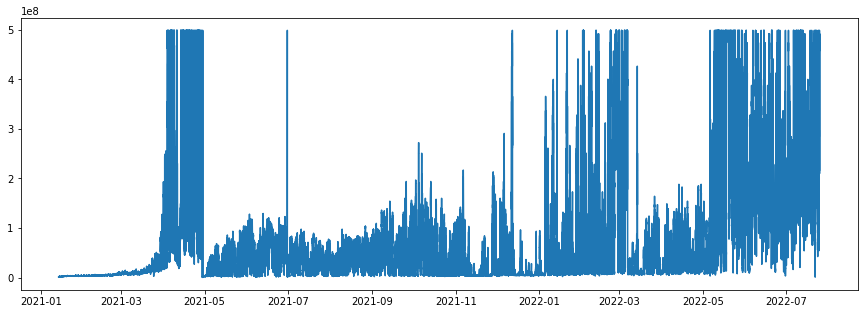

In [458]:
plt.figure(figsize=(15,5))
#plt.plot(norm(appa_clean[(appa_clean.index < "2021-06-30")].ZnOR_1) * max(appa_clean[(appa_clean.index > "2021-06-30")].ZnOR_1))
plt.plot(appa_clean.WO3_2)
plt.show()

In [452]:
appa_clean.loc[(appa_clean.index < "2021-06-30"), "ZnOR_2"] = norm(appa_clean[(appa_clean.index < "2021-06-30")].ZnOR_1) * max(appa_clean[(appa_clean.index > "2021-06-30")].ZnOR_2)

In [41]:
appa1_hr = pd.read_csv("exports/appa_clean.csv")
appa1_gt = pd.read_csv("exports/appa1_gt_clean_withCO.csv")

NameError: name 'pd' is not defined

In [141]:
appa1_clean.columns

Index(['Time', 'ZnOR_1', 'ZnOR_2', 'LaFeO3_1', 'LaFeO3_2', 'WO3_1', 'WO3_2',
       'ZnOR_heatR_1', 'ZnOR_heatR_2', 'LaFeO3_heatR_1', 'LaFeO3_heatR_2',
       'WO3_heatR_1', 'WO3_heatR_2', 'ZnOR_heatV_1', 'ZnOR_heatV_2',
       'LaFeO3_heatV_1', 'LaFeO3_heatV_2', 'WO3_heatV_1', 'WO3_heatV_2',
       'Temperature', 'Relative_Humidity', 'Pressure', 'VOC'],
      dtype='object')

In [142]:
appa1_hr = pd.DataFrame(columns = ['Time', 'ZnOR_1', 'ZnOR_2', 'LaFeO3_1', 'LaFeO3_2', 'WO3_1', 'WO3_2',
       'ZnOR_heatR_1', 'ZnOR_heatR_2', 'LaFeO3_heatR_1', 'LaFeO3_heatR_2',
       'WO3_heatR_1', 'WO3_heatR_2', 'ZnOR_heatV_1', 'ZnOR_heatV_2',
       'LaFeO3_heatV_1', 'LaFeO3_heatV_2', 'WO3_heatV_1', 'WO3_heatV_2',
       'Temperature', 'Relative_Humidity', 'Pressure', 'VOC'])

#for i in tqdm(range(0, len(appa1_clean)-60, 60), total=int(len(appa1_clean)-60)/60):
#       row = appa1_clean.iloc[i:i+60].mean(axis=0)
#       temp = [appa1_clean.iloc[i].Time]
#       temp[1:] = row
#       appa1_hr.loc[len(appa1_hr.index)] = temp


In [159]:
appa1_hr.Time = pd.to_datetime(appa1_hr.Time)
appa1_hr.Time = appa1_hr.Time.dt.tz_localize(None)
appa1_hr = appa1_hr.set_index("Time")

In [161]:
appa1_hr = appa1_hr.resample("H").mean()
#appa1_hr.Time = pd.to_datetime(appa1_hr.Time)
#for i, row in tqdm(appa1_hr.iterrows(), total = len(appa1_hr)):
#    appa1_hr.at[i, "Time"] = row.Time.replace(microsecond=0, second=0, minute=0)

appa1_gt.Time = pd.to_datetime(appa1_gt.Time)


In [162]:
appa1_hr

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,ZnOR_heatV_1,ZnOR_heatV_2,LaFeO3_heatV_1,LaFeO3_heatV_2,WO3_heatV_1,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,87.505000,...,4.038500,3.981833,3.007167,3.070167,4.022667,4.029667,48.851667,3.573333,988.271667,2961.030333
2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,87.311667,...,4.038000,3.980000,3.002167,3.069833,4.020333,4.028833,44.975000,4.228333,987.405000,3136.489667
2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,87.349153,...,4.037288,3.981186,3.002881,3.070000,4.020508,4.029492,45.900000,3.944068,986.586441,3203.500339
2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,87.360000,...,4.036333,3.981167,3.004000,3.070333,4.021333,4.029833,46.176667,3.858333,985.620000,3250.973833
2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,87.338333,...,4.039000,3.981167,3.002667,3.070000,4.022500,4.029833,46.108333,3.816667,984.713333,3366.150333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,110.933333,...,3.894500,4.022167,3.910833,3.645833,2.390000,2.569833,36.151667,29.928333,989.363333,3469.393333
2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,111.001667,...,3.893000,4.021833,3.910000,3.645667,2.389500,2.569167,36.963333,27.708333,988.421667,4580.721000
2022-07-25 13:00:00,4.990000e+08,4.990000e+08,9.389792e+06,733256.700000,5.941493e+07,4.832119e+08,128.315000,128.750000,500.000000,111.010000,...,3.894500,4.022500,3.908500,3.645167,2.390000,2.569667,37.466667,26.448333,987.286667,5309.537333


In [163]:
appa1_hr

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,ZnOR_heatV_1,ZnOR_heatV_2,LaFeO3_heatV_1,LaFeO3_heatV_2,WO3_heatV_1,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC
Time,,,,,,,,,,,,,,,,,,,,,
2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,87.505000,...,4.038500,3.981833,3.007167,3.070167,4.022667,4.029667,48.851667,3.573333,988.271667,2961.030333
2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,87.311667,...,4.038000,3.980000,3.002167,3.069833,4.020333,4.028833,44.975000,4.228333,987.405000,3136.489667
2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,87.349153,...,4.037288,3.981186,3.002881,3.070000,4.020508,4.029492,45.900000,3.944068,986.586441,3203.500339
2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,87.360000,...,4.036333,3.981167,3.004000,3.070333,4.021333,4.029833,46.176667,3.858333,985.620000,3250.973833
2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,87.338333,...,4.039000,3.981167,3.002667,3.070000,4.022500,4.029833,46.108333,3.816667,984.713333,3366.150333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,110.933333,...,3.894500,4.022167,3.910833,3.645833,2.390000,2.569833,36.151667,29.928333,989.363333,3469.393333
2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,111.001667,...,3.893000,4.021833,3.910000,3.645667,2.389500,2.569167,36.963333,27.708333,988.421667,4580.721000
2022-07-25 13:00:00,4.990000e+08,4.990000e+08,9.389792e+06,733256.700000,5.941493e+07,4.832119e+08,128.315000,128.750000,500.000000,111.010000,...,3.894500,4.022500,3.908500,3.645167,2.390000,2.569667,37.466667,26.448333,987.286667,5309.537333


In [164]:
appa1_hr = appa1_hr.merge(appa1_gt, how='left', on="Time")


In [148]:
appa1_gt

,Unnamed: 0,Time,PM10,NO2,SO2,O3,CO
0,72,2020-08-03 04:00:00,9.0,7.0,1.0,82.0,0.688000
1,73,2020-08-03 05:00:00,9.0,12.0,1.0,68.0,0.692000
2,74,2020-08-03 06:00:00,8.0,15.0,1.0,60.0,0.691333
3,75,2020-08-03 07:00:00,8.0,26.0,1.0,47.0,0.734000
4,76,2020-08-03 08:00:00,8.0,21.0,1.0,53.0,0.705333
...,...,...,...,...,...,...,...
17573,17646,2022-07-25 20:00:00,27.0,15.0,3.0,164.0,0.818667
17574,17647,2022-07-25 21:00:00,32.0,11.0,2.0,152.0,0.787333
17575,17648,2022-07-25 22:00:00,28.0,7.0,1.0,112.0,0.779333
17576,17649,2022-07-25 23:00:00,29.0,8.0,1.0,93.0,0.788000


In [165]:
appa1_hr

,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,...,Temperature,Relative_Humidity,Pressure,VOC,Unnamed: 0,PM10,NO2,SO2,O3,CO
0,2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,...,48.851667,3.573333,988.271667,2961.030333,3936.0,41.0,83.0,6.0,5.0,1.242000
1,2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,...,44.975000,4.228333,987.405000,3136.489667,3937.0,42.0,78.0,5.0,5.0,1.250667
2,2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,...,45.900000,3.944068,986.586441,3203.500339,3938.0,40.0,78.0,6.0,4.0,1.244000
3,2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,...,46.176667,3.858333,985.620000,3250.973833,3939.0,42.0,79.0,6.0,4.0,1.262000
4,2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,...,46.108333,3.816667,984.713333,3366.150333,3940.0,38.0,74.0,5.0,3.0,1.190667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14460,2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,...,36.151667,29.928333,989.363333,3469.393333,17639.0,20.0,14.0,3.0,141.0,0.811333
14461,2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,...,36.963333,27.708333,988.421667,4580.721000,17640.0,18.0,10.0,3.0,165.0,0.810000
14462,2022-07-25 13:00:00,4.990000e+08,4.990000e+08,9.389792e+06,733256.700000,5.941493e+07,4.832119e+08,128.315000,128.750000,500.000000,...,37.466667,26.448333,987.286667,5309.537333,17641.0,17.0,8.0,3.0,169.0,0.817333
14463,2022-07-25 14:00:00,4.990000e+08,4.990000e+08,1.041554e+07,737042.266667,4.473812e+07,3.280199e+08,128.410000,128.931667,500.000000,...,39.230000,22.996667,986.121667,5605.354833,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
appa1_hr = appa1_hr.drop("Unnamed: 0", axis=1)

In [151]:
appa1_hr

,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,LaFeO3_heatR_2,...,Temperature,Relative_Humidity,Pressure,VOC,Time,PM10,NO2,SO2,O3,CO


In [181]:
appa1_hr_cropped

,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,...,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC,PM10,NO2,SO2,O3,CO
0,2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,...,4.029667,48.851667,3.573333,988.271667,2961.030333,41.0,83.0,6.0,5.0,1.242000
1,2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,...,4.028833,44.975000,4.228333,987.405000,3136.489667,42.0,78.0,5.0,5.0,1.250667
2,2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,...,4.029492,45.900000,3.944068,986.586441,3203.500339,40.0,78.0,6.0,4.0,1.244000
3,2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,...,4.029833,46.176667,3.858333,985.620000,3250.973833,42.0,79.0,6.0,4.0,1.262000
4,2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,...,4.029833,46.108333,3.816667,984.713333,3366.150333,38.0,74.0,5.0,3.0,1.190667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14458,2022-07-25 09:00:00,4.990000e+08,4.990000e+08,2.746416e+06,896828.316667,2.570732e+07,1.694804e+08,128.053333,128.596667,500.000000,...,2.569167,35.240000,32.350000,990.885000,2222.511000,25.0,27.0,4.0,86.0,0.813333
14459,2022-07-25 10:00:00,4.990000e+08,4.990000e+08,3.817816e+06,823806.716667,3.907949e+07,2.790144e+08,128.138333,128.601667,500.000000,...,2.570500,35.500000,31.666667,990.255000,2702.818500,24.0,14.0,3.0,118.0,0.815333
14460,2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,500.000000,...,2.569833,36.151667,29.928333,989.363333,3469.393333,20.0,14.0,3.0,141.0,0.811333
14461,2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,500.000000,...,2.569167,36.963333,27.708333,988.421667,4580.721000,18.0,10.0,3.0,165.0,0.810000


In [171]:
appa1_hr_cropped = appa1_hr.dropna()
appa1_hr_cropped.to_csv("exports/appa1_hr_cropped.csv")

In [168]:
appa1_hr_cropped.NO2.sum()/13701

26.73958105247792

In [154]:
appa1_hr_cropped.iloc[:, 24]

Series([], Name: NO2, dtype: float64)

In [572]:
appa1_hr_cropped.head()

,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,...,WO3_heatV_2,Temperature,Relative_Humidity,Pressure,VOC,PM10,NO2,SO2,O3,CO
0,2021-01-14 00:00:00,868298.139714,868298.139714,643990.633333,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,...,4.029667,48.851667,3.573333,988.271667,2961.030333,41.0,83.0,6.0,5.0,1.242000
1,2021-01-14 01:00:00,959319.183333,959319.183333,650879.083333,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,...,4.028833,44.975000,4.228333,987.405000,3136.489667,42.0,78.0,5.0,5.0,1.250667
2,2021-01-14 02:00:00,947694.496425,947694.496425,651594.152542,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,...,4.029492,45.900000,3.944068,986.586441,3203.500339,40.0,78.0,6.0,4.0,1.244000
3,2021-01-14 03:00:00,953984.236589,953984.236589,653244.866667,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,...,4.029833,46.176667,3.858333,985.620000,3250.973833,42.0,79.0,6.0,4.0,1.262000
4,2021-01-14 04:00:00,988029.291276,988029.291276,651583.400000,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,...,4.029833,46.108333,3.816667,984.713333,3366.150333,38.0,74.0,5.0,3.0,1.190667


In [586]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,median_absolute_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
import statistics

In [602]:
#Predicting NO2 Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 24] , test_size=0.2, random_state=i)
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Baseline Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")


Gradient Boosted Baseline Predicting NO2
5.509509132820765 mean absolute error with a standard deviation of 0.10753855692160821
3.982904512088055 median absolute error with a standard deviation of 0.16043045496378208


In [603]:
#Predicting O3 Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 26] , test_size=0.2, random_state=i)
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Baseline Predicting O3")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")


Gradient Boosted Baseline Predicting O3
5.003219631966614 mean absolute error with a standard deviation of 0.1349182802068448
3.305683077464954 median absolute error with a standard deviation of 0.11765352697065579


In [612]:
#Predicting CO Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 27] , test_size=0.2, random_state=i)
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Baseline Predicting CO")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")


Gradient Boosted Baseline Predicting CO
0.036712045094642064 mean absolute error with a standard deviation of 0.0008381792245328511
0.023891341529203802 median absolute error with a standard deviation of 0.0006288305282199735


In [614]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [622]:
#Predicting NO2 Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 24] , test_size=0.2, random_state=i)
    regr = make_pipeline(StandardScaler(), SVR(C=50, epsilon=0.2))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print(scores_mean)
print("SVR Baseline Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

[6.207703859896952, 6.3701911756415734, 6.226507357894702, 6.376407911442551, 6.459825355099731]
SVR Baseline Predicting NO2
6.328127131995102 mean absolute error with a standard deviation of 0.10755601139860048
4.522971284181539 median absolute error with a standard deviation of 0.15138484845572617


In [624]:
#Predicting O3 Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 26] , test_size=0.2, random_state=i)
    regr = make_pipeline(StandardScaler(), SVR(C=50, epsilon=0.2))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("SVR Baseline Predicting O3")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

SVR Baseline Predicting O3
5.540535789695163 mean absolute error with a standard deviation of 0.11731516491637697
3.3447417497318055 median absolute error with a standard deviation of 0.10273737787391435


In [625]:
#Predicting CO Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 27] , test_size=0.2, random_state=i)
    regr = make_pipeline(StandardScaler(), SVR(C=50, epsilon=0.2))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("SVR Baseline Predicting CO")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

SVR Baseline Predicting CO
0.07789471468265188 mean absolute error with a standard deviation of 0.0016780701686168787
0.06787383968768212 median absolute error with a standard deviation of 0.0024555821096085813


In [318]:
appa1_sensor = pd.read_csv("appa1_adjusted.csv")

In [319]:
appa1_sensor = appa1_sensor.rename(columns={"ts":"Time"})

In [320]:
appa1_sensor

,Time,sensing_material,signal_res,heater_res,heater_volt,T,RH,P,sin_hour,cos_hour,sin_ordate,cos_ordate,sin_weekday,cos_weekday,year,age
0,2021-01-13 08:00:00,ZnOR,7.513813e+07,67.050000,1.431667,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
1,2021-01-13 08:00:00,ZnOR,7.495123e+07,66.125000,1.475833,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
2,2021-01-13 08:00:00,LaFeO3,7.472385e+07,70.991667,1.843333,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
3,2021-01-13 08:00:00,LaFeO3,2.713244e+07,69.975000,1.802500,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
4,2021-01-13 08:00:00,WO3,4.990000e+08,64.950000,1.730000,26.691667,22.616667,991.958333,0.259013,-0.038092,-0.000596,0.017157,0.816183,-0.373533,2021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107171,2022-07-25 14:00:00,WO3,2.151412e+08,147.500000,2.565000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,452
107172,2022-07-25 14:00:00,ZnOR,4.990000e+08,128.450000,3.890000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,558
107173,2022-07-25 14:00:00,ZnOR,4.990000e+08,129.150000,4.020000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,558
107174,2022-07-25 14:00:00,SmFeO3,3.208780e+07,103.800000,3.950000,41.850000,19.950000,985.550000,0.259340,0.035798,-0.016226,0.005605,0.000000,0.897598,2022,192


In [321]:
#2021-01-14 00:00:00
appa1_sensor = appa1_sensor.iloc[128:]

In [322]:
appa1_sensor = appa1_sensor.iloc[:107040]

In [323]:
appa1_sensor = appa1_sensor.drop("year", axis=1)

In [324]:
no2 = []
co = []
o3 = []
index = 0
time = appa1_sensor.iloc[0].Time
for i, row in tqdm(appa1_sensor.iterrows(), total=len(appa1_sensor)):
    if time == str(row.Time):
        no2.append(appa1_hr_cropped.iloc[index].NO2)
        co.append(appa1_hr_cropped.iloc[index].CO)
        o3.append(appa1_hr_cropped.iloc[index].O3)
    else:
        index+=1
        time = row.Time
        no2.append(appa1_hr_cropped.iloc[index].NO2)
        co.append(appa1_hr_cropped.iloc[index].CO)
        o3.append(appa1_hr_cropped.iloc[index].O3)


100%|██████████| 107040/107040 [00:36<00:00, 2960.66it/s]


In [325]:
appa1_sensor["NO2"] = no2
appa1_sensor["CO"] = co
appa1_sensor["O3"] = o3

In [326]:
appa1_sensor

,Time,sensing_material,signal_res,heater_res,heater_volt,T,RH,P,sin_hour,cos_hour,sin_ordate,cos_ordate,sin_weekday,cos_weekday,age,NO2,CO,O3
128,2021-01-14 00:00:00,ZnOR,2.227298e+05,102.151667,4.038500,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
129,2021-01-14 00:00:00,ZnOR,1.239792e+05,99.416667,3.981833,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
130,2021-01-14 00:00:00,LaFeO3,6.439906e+05,88.176667,3.007167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
131,2021-01-14 00:00:00,LaFeO3,5.119072e+05,87.505000,3.070167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
132,2021-01-14 00:00:00,WO3,8.852432e+05,39.276667,4.022667,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107163,2022-07-25 13:00:00,WO3,3.280199e+08,147.463333,2.570000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,452,9.0,0.737333,85.0
107164,2022-07-25 13:00:00,ZnOR,4.990000e+08,128.410000,3.895000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107165,2022-07-25 13:00:00,ZnOR,4.990000e+08,128.931667,4.024000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107166,2022-07-25 13:00:00,SmFeO3,2.723392e+07,103.621667,3.950000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,192,9.0,0.737333,85.0


In [327]:
for i, row in tqdm(appa1_sensor.iterrows(), total=len(appa1_sensor)):
    if row.sensing_material == "ZnO":
        appa1_sensor.at[i, "sensing_material"] = 1
    elif row.sensing_material == "LaFeO3":
        appa1_sensor.at[i, "sensing_material"] = 2
    elif row.sensing_material == "WO3":
        appa1_sensor.at[i, "sensing_material"] = 3
    elif row.sensing_material == "ZnOR":
        appa1_sensor.at[i, "sensing_material"] = 4
    elif row.sensing_material == "ZnOg":
        appa1_sensor.at[i, "sensing_material"] = 5
    elif row.sensing_material == "SmFe03":
        appa1_sensor.at[i, "sensing_material"] = 6
    else:
        appa1_sensor.at[i, "sensing_material"] = 7

100%|██████████| 107040/107040 [00:06<00:00, 17183.18it/s]


In [329]:
#Predicting NO2 with sensors as features
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,median_absolute_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(appa1_sensor.iloc[:, 1:15], appa1_sensor.iloc[:, 17] , test_size=0.2, random_state=42)

In [331]:
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

Gradient Boosting
Median Error: 13.473079683495286 
 Mean error: 16.96630783384489 
 Mean Squared Error: 472.1120453730076


In [338]:
appa1_sensor

,Time,sensing_material,signal_res,heater_res,heater_volt,T,RH,P,sin_hour,cos_hour,sin_ordate,cos_ordate,sin_weekday,cos_weekday,age,NO2,CO,O3
128,2021-01-14 00:00:00,4,2.227298e+05,102.151667,4.038500,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
129,2021-01-14 00:00:00,4,1.239792e+05,99.416667,3.981833,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
130,2021-01-14 00:00:00,2,6.439906e+05,88.176667,3.007167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
131,2021-01-14 00:00:00,2,5.119072e+05,87.505000,3.070167,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
132,2021-01-14 00:00:00,3,8.852432e+05,39.276667,4.022667,48.851667,3.573333,988.271667,0.000000,0.261799,0.014115,0.009771,0.126669,-0.888615,1,83.0,1.242000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107163,2022-07-25 13:00:00,3,3.280199e+08,147.463333,2.570000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,452,9.0,0.737333,85.0
107164,2022-07-25 13:00:00,4,4.990000e+08,128.410000,3.895000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107165,2022-07-25 13:00:00,4,4.990000e+08,128.931667,4.024000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,558,9.0,0.737333,85.0
107166,2022-07-25 13:00:00,7,2.723392e+07,103.621667,3.950000,39.230000,22.996667,986.121667,0.109999,0.237569,-0.016226,0.005605,0.000000,0.897598,192,9.0,0.737333,85.0


In [348]:
appa1_sensor_LaFeO3 = pd.DataFrame()
appa1_sensor_WO3 = pd.DataFrame()
appa1_sensor_ZnOR = pd.DataFrame()

for i, row in tqdm(appa1_sensor.iterrows(), total=len(appa1_sensor)):
    if row.sensing_material == 2:
        appa1_sensor_LaFeO3 = appa1_sensor_LaFeO3.append(row)
    elif row.sensing_material == 3:
        appa1_sensor_WO3 = appa1_sensor_WO3.append(row)
    elif row.sensing_material == 4:
        appa1_sensor_ZnOR = appa1_sensor_ZnOR.append(row)


100%|██████████| 107040/107040 [03:38<00:00, 489.97it/s]


In [360]:
#LaFe03 Predicting O3
X_train, X_test, y_train, y_test = train_test_split(appa1_sensor_LaFeO3.iloc[:, 1:15], appa1_sensor_LaFeO3.iloc[:, 17] , test_size=0.2, random_state=42)
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

IndexError: single positional indexer is out-of-bounds

In [358]:
#WO3 Predicting O3
X_train, X_test, y_train, y_test = train_test_split(appa1_sensor_WO3.iloc[:, 1:15], appa1_sensor_WO3.iloc[:, 17] , test_size=0.2, random_state=42)
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

Gradient Boosting
Median Error: 12.563385403826528 
 Mean error: 16.009485807104177 
 Mean Squared Error: 426.5869003602038


In [359]:
#ZnOR Predicting O3
X_train, X_test, y_train, y_test = train_test_split(appa1_sensor_ZnOR.iloc[:, 1:15], appa1_sensor_ZnOR.iloc[:, 17] , test_size=0.2, random_state=42)
reg = GradientBoostingRegressor(random_state=0, n_estimators=400) 
reg.fit(X_train, y_train)
y_test_pred = reg.predict(X_test)
print("Gradient Boosting")
print(f"Median Error: {median_absolute_error(y_test, y_test_pred)} \n Mean error: {mean_absolute_error(y_test, y_test_pred)} \n Mean Squared Error: {mean_squared_error(y_test, y_test_pred)}")

Gradient Boosting
Median Error: 12.284831980893447 
 Mean error: 15.65906107846902 
 Mean Squared Error: 415.6121273396209


In [627]:
#Predicting O3

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        #print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 26] , test_size=0.2, random_state=i)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN Baseline Predicting O3")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")



100%|██████████| 5/5 [17:14<00:00, 206.95s/it]

NN Baseline Predicting O3
1.0960124177397073 mean absolute error with a standard deviation of 0.020350146727014618
1.0158088795284441 median absolute error with a standard deviation of 0.010521829918651877


In [632]:
#Predicting CO

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        #print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 27] , test_size=0.2, random_state=i)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN Baseline Predicting CO")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")



100%|██████████| 5/5 [22:32<00:00, 270.50s/it]

NN Baseline Predicting CO
1.156501625923186 mean absolute error with a standard deviation of 0.020429754336398737
1.1897109802107988 median absolute error with a standard deviation of 0.022492564113336583


In [628]:
#Predicting NO2

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        #print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 24] , test_size=0.2, random_state=i)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN Baseline Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")



100%|██████████| 5/5 [17:12<00:00, 206.42s/it]

NN Baseline Predicting NO2
1.1436117055058 mean absolute error with a standard deviation of 0.028202564401840578
1.2291190357986816 median absolute error with a standard deviation of 0.02751211884708344


In [638]:
# NN + ALR Baseline Prediction NO2


import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    lr = 0.001
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        # print(f"epoch {epoch} done, loss {loss}, learning rate {lr/(1+(epoch/10))}")
        optimizer = torch.optim.SGD(net.parameters(), lr=lr/(1+(epoch/10)), momentum = 0.3)

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 24] , test_size=0.2, random_state=i+5)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN + ALR Baseline Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

100%|██████████| 5/5 [22:14<00:00, 266.82s/it]

NN + ALR Baseline Predicting NO2
1.1554058381934875 mean absolute error with a standard deviation of 0.015397045770227076
1.2338690416811362 median absolute error with a standard deviation of 0.01955904982243242


In [639]:
# NN + ALR Baseline Prediction O3


import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    lr = 0.001
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        # print(f"epoch {epoch} done, loss {loss}, learning rate {lr/(1+(epoch/10))}")
        optimizer = torch.optim.SGD(net.parameters(), lr=lr/(1+(epoch/10)), momentum = 0.3)

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 26] , test_size=0.2, random_state=i+5)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN + ALR Baseline Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

100%|██████████| 5/5 [23:13<00:00, 278.66s/it]

NN + ALR Baseline Predicting NO2
1.0923358888770156 mean absolute error with a standard deviation of 0.016019266554418377
1.0237255291144038 median absolute error with a standard deviation of 0.022830281442216122


In [640]:
# NN + ALR Baseline Prediction CO


import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    lr = 0.001
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        # print(f"epoch {epoch} done, loss {loss}, learning rate {lr/(1+(epoch/10))}")
        optimizer = torch.optim.SGD(net.parameters(), lr=lr/(1+(epoch/10)), momentum = 0.3)

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_hr_cropped.iloc[:, 1:23], appa1_hr_cropped.iloc[:, 27] , test_size=0.2, random_state=i+5)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN + ALR Baseline Predicting CO")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

100%|██████████| 5/5 [29:17<00:00, 351.41s/it]

NN + ALR Baseline Predicting CO
1.163013074647936 mean absolute error with a standard deviation of 0.006353287321419476
1.1886057918097563 median absolute error with a standard deviation of 0.007148236996021882


In [642]:
appa1_weather.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'Time', 'ZnOR_1', 'ZnOR_2', 'LaFeO3_1',
       'LaFeO3_2', 'WO3_1', 'WO3_2', 'ZnOR_heatR_1', 'ZnOR_heatR_2',
       'LaFeO3_heatR_1', 'LaFeO3_heatR_2', 'WO3_heatR_1', 'WO3_heatR_2',
       'ZnOR_heatV_1', 'ZnOR_heatV_2', 'LaFeO3_heatV_1', 'LaFeO3_heatV_2',
       'WO3_heatV_1', 'WO3_heatV_2', 'Temperature', 'Relative_Humidity',
       'Pressure', 'VOC', 'PM10', 'NO2', 'SO2', 'O3', 'CO', 'ronc uv',
       'ronc rain', 'ronc w_sp', 'ronc w_dir', 'laste uv', 'laste rain',
       'laste w_sp', 'laste w_dir'],
      dtype='object')

In [646]:
appa1_weather = pd.read_csv("exports/appa1_weather.csv")
appa1_weather = appa1_weather[[c for c in appa1_weather if c not in ['NO2', 'SO2', 'O3', 'CO']] 
       + ['NO2', 'SO2', 'O3', 'CO']]
appa1_weather = appa1_weather.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], axis=1)
appa1_weather.head()

,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,LaFeO3_heatR_1,...,ronc w_sp,ronc w_dir,laste uv,laste rain,laste w_sp,laste w_dir,NO2,SO2,O3,CO
0,2021-01-14 00:00:00,868298.139714,868298.139714,643990.633333,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,88.176667,...,0.733333,177.000000,0.0,0.0,3.250000,54.000000,83.0,6.0,5.0,1.242000
1,2021-01-14 01:00:00,959319.183333,959319.183333,650879.083333,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,87.950000,...,0.733333,120.333333,0.0,0.0,1.883333,35.500000,78.0,5.0,5.0,1.250667
2,2021-01-14 02:00:00,947694.496425,947694.496425,651594.152542,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,87.988136,...,0.650000,136.500000,0.0,0.0,1.283333,102.000000,78.0,6.0,4.0,1.244000
3,2021-01-14 03:00:00,953984.236589,953984.236589,653244.866667,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,88.010000,...,0.816667,166.833333,0.0,0.0,1.000000,103.500000,79.0,6.0,4.0,1.262000
4,2021-01-14 04:00:00,988029.291276,988029.291276,651583.400000,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,87.995000,...,0.616667,170.666667,0.0,0.0,1.600000,45.666667,74.0,5.0,3.0,1.190667


In [651]:
#Predicting NO2 Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 32] , test_size=0.2, random_state=i)
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Weather Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")


Gradient Boosted Weather Predicting NO2
4.8367991222132565 mean absolute error with a standard deviation of 0.08472353053494579
3.4522267328642484 median absolute error with a standard deviation of 0.111841131645572


In [652]:
#Predicting O3 Weather
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 34] , test_size=0.2, random_state=i)
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Weather Predicting O3")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")


Gradient Boosted Weather Predicting O3
4.618411612819773 mean absolute error with a standard deviation of 0.16564766325985492
3.0502599798464267 median absolute error with a standard deviation of 0.09278823209316793


In [653]:
#Predicting CO Baseline
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 35] , test_size=0.2, random_state=i)
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Weather Predicting CO")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")


Gradient Boosted Weather Predicting CO
0.030100769325290443 mean absolute error with a standard deviation of 0.0006271757885598681
0.02034463362171628 median absolute error with a standard deviation of 0.0003832829528798987


In [656]:
#Predicting NO2 Weather
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 32] , test_size=0.2, random_state=i)
    regr = make_pipeline(StandardScaler(), SVR(C=50, epsilon=0.2))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print(scores_mean)
print("SVR Weather Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

[5.075646524360988, 5.184433393728533, 4.980499010803322, 5.216443724359959, 5.21018325075763]
SVR Weather Predicting NO2
5.133441180802086 mean absolute error with a standard deviation of 0.102604218960954
3.414505039147675 median absolute error with a standard deviation of 0.11902933654203049


In [657]:
#Predicting O3 Weather
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 34] , test_size=0.2, random_state=i)
    regr = make_pipeline(StandardScaler(), SVR(C=50, epsilon=0.2))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print(scores_mean)
print("SVR Weather Predicting O3")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

[4.722968964723536, 4.718550681226429, 4.760656582799018, 4.808218452105858, 4.841508522031725]
SVR Weather Predicting O3
4.770380640577313 mean absolute error with a standard deviation of 0.053664803397376115
2.921172654648477 median absolute error with a standard deviation of 0.035442372889405334


In [658]:
#Predicting CO Weather
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 35] , test_size=0.2, random_state=i)
    regr = make_pipeline(StandardScaler(), SVR(C=50, epsilon=0.2))
    regr.fit(X_train, y_train)
    y_test_pred = regr.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print(scores_mean)
print("SVR Weather Predicting CO")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

[0.07209937950847589, 0.0768003372890836, 0.07606013207219153, 0.07318261060162821, 0.07425386976368138]
SVR Weather Predicting CO
0.07447926584701212 mean absolute error with a standard deviation of 0.0019546411349162405
0.06538290774998716 median absolute error with a standard deviation of 0.0024062776699654564


In [661]:
#Predicting NO2 Weather

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(30, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        #print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

#appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 32] , test_size=0.2, random_state=i)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(scalerY_test.inverse_transform(evals[1]), scalerY_train.inverse_transform(evals[0])))
    scores_median.append(median_absolute_error(scalerY_test.inverse_transform(evals[1]), scalerY_train.inverse_transform(evals[0])))
    print(scores)

print("NN Weather Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

100%|██████████| 5/5 [19:59<00:00, 239.92s/it]

NN Weather Predicting NO2
1.147794045454913 mean absolute error with a standard deviation of 0.03057844589654115
1.2309283601976335 median absolute error with a standard deviation of 0.02927663651895581


In [662]:
#Predicting O3 Weather

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(30, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        #print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

#appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 34] , test_size=0.2, random_state=i)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN Weather Predicting O3")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

100%|██████████| 5/5 [17:01<00:00, 204.39s/it]

NN Weather Predicting O3
1.0946357881114497 mean absolute error with a standard deviation of 0.013568304987923083
1.0175058118987763 median absolute error with a standard deviation of 0.014042335900157401


In [664]:
#Predicting CO Weather

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(30, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        #print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

#appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 35] , test_size=0.2, random_state=i+5)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN Weather Predicting CO")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

100%|██████████| 5/5 [16:55<00:00, 203.18s/it]

NN Weather Predicting CO
1.1681603249425856 mean absolute error with a standard deviation of 0.005708263712760058
1.1955580685682632 median absolute error with a standard deviation of 0.008458341399300441


In [712]:
# NN + ALR Baseline Prediction NO2


import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(30, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    lr = 0.001
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        # print(f"epoch {epoch} done, loss {loss}, learning rate {lr/(1+(epoch/10))}")
        optimizer = torch.optim.SGD(net.parameters(), lr=lr/(1+(epoch/10)), momentum = 0.3)

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

appa1_hr_cropped = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
scores_mean = []
scores_median = []
for i in tqdm(range(5), total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, 32] , test_size=0.2, random_state=i+5)

    net = Net()
    y_train = np.array([[i] for i in list(y_train)])
    y_test = np.array([[i] for i in list(y_test)])

    loss_fn = T.nn.CrossEntropyLoss()
    optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scalerX = preprocessing.StandardScaler().fit(X_train)
    X_train = scalerX.transform(X_train)
    scalerX = preprocessing.StandardScaler().fit(X_test)
    X_test = scalerX.transform(X_test)
    scalerY_train = preprocessing.StandardScaler().fit(y_train)
    y_train = scalerY_train.transform(y_train)
    scalerY_test = preprocessing.StandardScaler().fit(y_test)
    y_test = scalerY_train.transform(y_test)
    data_train = []
    data_test = []
    i = 0
    for row in X_train:
        data_train.append((row, y_train[i]))
        i = i+1
    i = 0
    for row in X_test:
        data_test.append((row, y_test[i]))
        i = i+1

    train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
    test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

    train_model(train_dl, net)
    evals = evaluate_model(test_dl, bm)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))

print("NN + ALR Weather Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

  0%|          | 0/5 [04:35<?, ?it/s]


ValueError: Found input variables with inconsistent numbers of samples: [3667, 2741]

<AxesSubplot:xlabel='Time'>

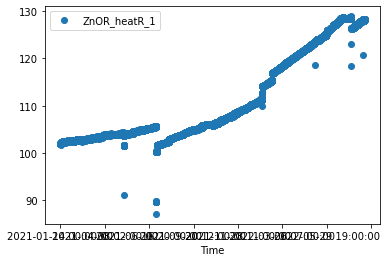

In [365]:
appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
appa1_outlier = appa1_outlier.drop("Unnamed: 0", axis=1)
appa1_outlier.plot(x='Time', y='ZnOR_heatR_1', style='o')

In [372]:

index = []
for i, row in appa1_outlier.iloc[:-2].iterrows():
    #print((row.ZnOR_heatR_1/appa1_outlier.iloc[i+1].ZnOR_heatR_1))
    if (row.ZnOR_heatR_1/appa1_outlier.iloc[i+1].ZnOR_heatR_1) > 1.03 or (row.ZnOR_heatR_1/appa1_outlier.iloc[i+1].ZnOR_heatR_1) < 0.97:
        index.append(i)
print(index)
appa1_outlier = appa1_outlier.drop(index)
appa1_outlier = appa1_outlier.reset_index(drop = True)


[4302, 4313]


[4307, 4317, 9086]


In [374]:
appa1_outlier = appa1_outlier.drop(4303)


<AxesSubplot:xlabel='Time'>

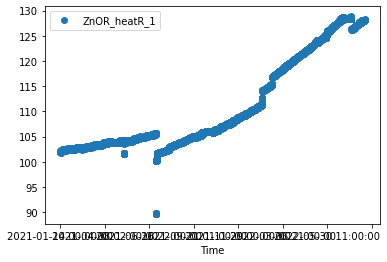

In [375]:
appa1_outlier.plot(x='Time', y='ZnOR_heatR_1', style='o')

In [415]:
appa1_outlier.columns[24]

'NO2'

In [386]:
#Predicting NO2 Weather NN + ALR

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:31], appa1_weather.iloc[:, ] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    lr = 0.001
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_NO2 = evaluate_model(test_dl, net)

print(f"{appa1_outlier.columns[24]}:")
print(f"Range of O3: {appa1_outlier.NO2.max()-appa1_outlier.NO2.min()}")
print(f"Mean of O3: {appa1_outlier.NO2.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_NO2[1]),  scalerY_train.inverse_transform(evals_NO2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_NO2[1]),  scalerY_train.inverse_transform(evals_NO2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_NO2[1]),  scalerY_train.inverse_transform(evals_NO2[0]))}")

epoch 0 done, loss 0.6746580600738525
epoch 1 done, loss 0.008086804300546646
epoch 2 done, loss 0.05368746072053909
epoch 3 done, loss 0.3077036142349243
epoch 4 done, loss 0.0422692634165287
epoch 5 done, loss 0.5397845506668091
epoch 6 done, loss 0.0050710951909422874
epoch 7 done, loss 0.17160016298294067
epoch 8 done, loss 0.3909554183483124
epoch 9 done, loss 0.0027226333040744066
epoch 10 done, loss 0.16274169087409973
epoch 11 done, loss 0.11183629184961319
epoch 12 done, loss 0.01830482669174671
epoch 13 done, loss 0.33612021803855896
epoch 14 done, loss 0.19879424571990967
epoch 15 done, loss 1.391037940979004
epoch 16 done, loss 0.105948805809021
epoch 17 done, loss 0.22263740003108978
epoch 18 done, loss 0.04654205963015556
epoch 19 done, loss 0.007149432320147753
epoch 20 done, loss 0.01593480259180069
epoch 21 done, loss 0.043992236256599426
epoch 22 done, loss 0.05541131645441055
epoch 23 done, loss 0.1821691393852234
epoch 24 done, loss 0.00010202820703852922
epoch 25 d

In [392]:
#Predicting SO2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_outlier.iloc[:, 1:23], appa1_outlier.iloc[:, 25] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_SO2 = evaluate_model(test_dl, net)

print(f"{appa1_outlier.columns[25]}:")
print(f"Range of O3: {appa1_outlier.SO2.max()-appa1_outlier.SO2.min()}")
print(f"Mean of O3: {appa1_outlier.SO2.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_SO2[1]),  scalerY_train.inverse_transform(evals_SO2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_SO2[1]),  scalerY_train.inverse_transform(evals_SO2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_SO2[1]),  scalerY_train.inverse_transform(evals_SO2[0]))}")


epoch 0 done, loss 0.03448998183012009
epoch 1 done, loss 0.04966016858816147
epoch 2 done, loss 0.5739729404449463
epoch 3 done, loss 1.6585254669189453
epoch 4 done, loss 0.3041258454322815
epoch 5 done, loss 0.05907471105456352
epoch 6 done, loss 0.8586041927337646
epoch 7 done, loss 0.01154305785894394
epoch 8 done, loss 0.04227825626730919
epoch 9 done, loss 1.1415349245071411
epoch 10 done, loss 0.08772598952054977
epoch 11 done, loss 0.17617671191692352
epoch 12 done, loss 0.15901228785514832
epoch 13 done, loss 0.0029237770941108465
epoch 14 done, loss 0.1611524224281311
epoch 15 done, loss 0.025158319622278214
epoch 16 done, loss 0.800988495349884
epoch 17 done, loss 7.026929233688861e-05
epoch 18 done, loss 2.2445123195648193
epoch 19 done, loss 1.071468472480774
epoch 20 done, loss 0.03584396839141846
epoch 21 done, loss 0.4913243353366852
epoch 22 done, loss 0.1169533059000969
epoch 23 done, loss 2.0990824699401855
epoch 24 done, loss 0.3381313681602478
epoch 25 done, loss 

In [398]:
#Predicting O3

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_outlier.iloc[:, 1:23], appa1_outlier.iloc[:, 26] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(22, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_O3 = evaluate_model(test_dl, net)

print(f"{appa1_outlier.columns[26]}:")
print(f"Range of O3: {appa1_outlier.O3.max()-appa1_outlier.O3.min()}")
print(f"Mean of O3: {appa1_outlier.O3.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_O3[1]),  scalerY_train.inverse_transform(evals_O3[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_O3[1]),  scalerY_train.inverse_transform(evals_O3[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_O3[1]),  scalerY_train.inverse_transform(evals_O3[0]))}")

epoch 0 done, loss 0.21158486604690552
epoch 1 done, loss 0.11331019550561905
epoch 2 done, loss 0.2579461932182312
epoch 3 done, loss 0.12592388689517975
epoch 4 done, loss 0.00374353164806962
epoch 5 done, loss 0.011756963096559048
epoch 6 done, loss 0.0016273113433271646
epoch 7 done, loss 0.010645021684467793
epoch 8 done, loss 0.5102201104164124
epoch 9 done, loss 0.0009337725350633264
epoch 10 done, loss 0.14860761165618896
epoch 11 done, loss 0.0018860652344301343
epoch 12 done, loss 0.04121752828359604
epoch 13 done, loss 0.017477218061685562
epoch 14 done, loss 0.11390170454978943
epoch 15 done, loss 0.006610895041376352
epoch 16 done, loss 0.00029863076633773744
epoch 17 done, loss 0.006298370193690062
epoch 18 done, loss 0.04022970795631409
epoch 19 done, loss 0.004122502636164427
epoch 20 done, loss 2.9403212465695105e-05
epoch 21 done, loss 0.029737668111920357
epoch 22 done, loss 0.003120224457234144
epoch 23 done, loss 0.018085816875100136
epoch 24 done, loss 0.001332162

In [419]:
appa2

,Time,LaFeO3_1,LaFeO3_2,STN_1,STN_2,LaFeO3_heatR_1,LaFeO3_heatR_2,STN_heatR_1,STN_heatR_2,LaFeO3_heatV_1,...,STN_heatV_1,STN_heatV_2,Temperature,Relative_Humidity,Pressure,VOC,LaFeO3_1_TimeSinceCreated,LaFeO3_2_TimeSinceCreated,STN_1_TimeSinceCreated,STN_2_TimeSinceCreated
0,2021-01-13 10:00:00+00:00,3.293993e+07,4.579655e+07,2.323119e+08,2.264656e+08,77.171739,76.676087,85.050000,83.717391,2.153696,...,2.745652,2.722826,30.823913,16.413043,994.056522,1381.336739,36000,36000,36000,36000
1,2021-01-13 11:00:00+00:00,2.648063e+05,3.220134e+05,6.017979e+07,4.924686e+07,90.883051,91.327119,105.518644,104.208475,3.234746,...,4.389153,4.351695,39.594915,9.179661,992.691525,1868.565932,39600,39600,39600,39600
2,2021-01-13 12:00:00+00:00,2.617744e+05,3.181149e+05,6.835107e+07,5.825682e+07,90.857627,91.277966,105.562712,104.216949,3.234746,...,4.390169,4.352373,39.227119,9.366102,991.983051,1887.251356,43200,43200,43200,43200
3,2021-01-13 13:00:00+00:00,2.601968e+05,3.162009e+05,7.191184e+07,6.151707e+07,90.866102,91.277966,105.537288,104.222034,3.233898,...,4.388814,4.352034,39.427119,9.438983,991.622034,1863.711017,46800,46800,46800,46800
4,2021-01-13 14:00:00+00:00,2.600834e+05,3.149274e+05,6.989441e+07,6.151416e+07,90.801695,91.294915,105.552542,104.169492,3.234068,...,4.388814,4.351186,38.484746,9.711864,991.632203,1845.569322,50400,50400,50400,50400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12425,2022-07-25 11:00:00+00:00,1.092741e+06,5.892058e+04,4.990000e+08,4.990000e+08,96.840678,94.028814,121.040678,117.074576,3.281356,...,4.270000,4.078136,39.523729,26.657627,990.896610,5557.048644,39092400,39092400,39092400,33735600
12426,2022-07-25 12:00:00+00:00,9.916030e+05,5.853149e+04,4.990000e+08,4.990000e+08,96.913559,94.176271,121.103390,117.188136,3.280847,...,4.270000,4.078305,40.447458,24.930508,989.783051,6800.150678,39096000,39096000,39096000,33739200
12427,2022-07-25 13:00:00+00:00,9.382152e+05,5.836902e+04,4.990000e+08,4.990000e+08,96.835593,93.779661,121.042373,117.123729,3.279831,...,4.268305,4.077627,40.357627,24.781356,988.783051,7490.784237,39099600,39099600,39099600,33742800
12428,2022-07-25 14:00:00+00:00,9.237312e+05,5.813959e+04,4.990000e+08,4.990000e+08,96.844068,93.059322,121.120339,117.108475,3.281525,...,4.268644,4.075424,40.801695,23.944068,987.733898,7699.991186,39103200,39103200,39103200,33746400


In [438]:
appa2 = pd.read_csv("exports/appa_hr_2_crop_withCreated.csv")
appa2_gt = pd.read_csv("appa2_gt.csv")
appa2.Time = pd.to_datetime(appa2.Time)
appa2_gt.Time = pd.to_datetime(appa2_gt.Time)
appa2.Time = appa2.Time.dt.tz_localize(None)
appa2 = appa2.merge(appa2_gt, how='left', on="Time")


In [439]:
appa2

,Time,LaFeO3_1,LaFeO3_2,STN_1,STN_2,LaFeO3_heatR_1,LaFeO3_heatR_2,STN_heatR_1,STN_heatR_2,LaFeO3_heatV_1,...,Relative_Humidity,Pressure,VOC,LaFeO3_1_TimeSinceCreated,LaFeO3_2_TimeSinceCreated,STN_1_TimeSinceCreated,STN_2_TimeSinceCreated,PM10,Ossido di Carbonio,Biossido di Azoto
0,2021-01-13 10:00:00,3.293993e+07,4.579655e+07,2.323119e+08,2.264656e+08,77.171739,76.676087,85.050000,83.717391,2.153696,...,16.413043,994.056522,1381.336739,36000,36000,36000,36000,53.0,0.9,76.0
1,2021-01-13 11:00:00,2.648063e+05,3.220134e+05,6.017979e+07,4.924686e+07,90.883051,91.327119,105.518644,104.208475,3.234746,...,9.179661,992.691525,1868.565932,39600,39600,39600,39600,53.0,0.8,67.0
2,2021-01-13 12:00:00,2.617744e+05,3.181149e+05,6.835107e+07,5.825682e+07,90.857627,91.277966,105.562712,104.216949,3.234746,...,9.366102,991.983051,1887.251356,43200,43200,43200,43200,48.0,0.7,68.0
3,2021-01-13 13:00:00,2.601968e+05,3.162009e+05,7.191184e+07,6.151707e+07,90.866102,91.277966,105.537288,104.222034,3.233898,...,9.438983,991.622034,1863.711017,46800,46800,46800,46800,43.0,0.7,71.0
4,2021-01-13 14:00:00,2.600834e+05,3.149274e+05,6.989441e+07,6.151416e+07,90.801695,91.294915,105.552542,104.169492,3.234068,...,9.711864,991.632203,1845.569322,50400,50400,50400,50400,46.0,0.7,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12614,2022-07-25 11:00:00,1.092741e+06,5.892058e+04,4.990000e+08,4.990000e+08,96.840678,94.028814,121.040678,117.074576,3.281356,...,26.657627,990.896610,5557.048644,39092400,39092400,39092400,33735600,24.0,0.9,19.0
12615,2022-07-25 12:00:00,9.916030e+05,5.853149e+04,4.990000e+08,4.990000e+08,96.913559,94.176271,121.103390,117.188136,3.280847,...,24.930508,989.783051,6800.150678,39096000,39096000,39096000,33739200,21.0,0.9,32.0
12616,2022-07-25 13:00:00,9.382152e+05,5.836902e+04,4.990000e+08,4.990000e+08,96.835593,93.779661,121.042373,117.123729,3.279831,...,24.781356,988.783051,7490.784237,39099600,39099600,39099600,33742800,20.0,0.9,33.0
12617,2022-07-25 14:00:00,9.237312e+05,5.813959e+04,4.990000e+08,4.990000e+08,96.844068,93.059322,121.120339,117.108475,3.281525,...,23.944068,987.733898,7699.991186,39103200,39103200,39103200,33746400,19.0,0.9,20.0


In [445]:
appa2 = appa2.dropna()
appa2 = appa2.rename(columns={"Ossido di Carbonio":"CO"})

In [467]:
#Predicting CO from APPA2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa2.iloc[:, 1:19], appa2.iloc[:, 22] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(18, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX.transform(X_train)
scalerX = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_CO_2 = evaluate_model(test_dl, net)

print(f"{appa2.columns[22]}:")
print(f"Range of CO: {appa2.CO.max()-appa2.CO.min()}")
print(f"Mean of CO: {appa2.CO.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")

epoch 0 done, loss 0.16935665905475616
epoch 1 done, loss 0.000157478847540915
epoch 2 done, loss 0.015889396890997887
epoch 3 done, loss 0.7129274010658264
epoch 4 done, loss 0.32052576541900635
epoch 5 done, loss 0.010584674775600433
epoch 6 done, loss 0.04678903520107269
epoch 7 done, loss 0.02022039331495762
epoch 8 done, loss 0.004029349889606237
epoch 9 done, loss 0.057541653513908386
epoch 10 done, loss 0.08385542780160904
epoch 11 done, loss 0.18111206591129303
epoch 12 done, loss 0.0012358822859823704
epoch 13 done, loss 0.019594622775912285
epoch 14 done, loss 0.011977807618677616
epoch 15 done, loss 0.00996311940252781
epoch 16 done, loss 0.015524609014391899
epoch 17 done, loss 0.0014919413952156901
epoch 18 done, loss 0.004074506927281618
epoch 19 done, loss 0.027677243575453758
epoch 20 done, loss 0.001955675892531872
epoch 21 done, loss 0.02263435162603855
epoch 22 done, loss 0.03609166294336319
epoch 23 done, loss 0.07846879214048386
epoch 24 done, loss 0.03080270998179

In [459]:
weather

,Time,ronc uv,ronc rain,ronc w_sp,ronc w_dir,laste uv,laste rain,laste w_sp,laste w_dir
0,2012-01-01 01:00:00,0.0,0.0,0.650000,211.416667,0.0,0.0,0.825000,100.750000
1,2012-01-01 02:00:00,0.0,0.0,0.633333,149.083333,0.0,0.0,0.675000,178.250000
2,2012-01-01 03:00:00,0.0,0.0,0.625000,221.083333,0.0,0.0,1.250000,168.750000
3,2012-01-01 04:00:00,0.0,0.0,0.600000,188.000000,0.0,0.0,0.925000,183.500000
4,2012-01-01 05:00:00,0.0,0.0,0.700000,194.500000,0.0,0.0,1.500000,261.250000
...,...,...,...,...,...,...,...,...,...
92707,2022-07-29 20:00:00,0.0,2.4,1.700000,318.666667,0.0,2.4,1.150000,270.500000
92708,2022-07-29 21:00:00,0.0,0.2,1.683333,226.166667,0.0,0.8,1.500000,276.666667
92709,2022-07-29 22:00:00,0.0,1.4,2.050000,318.000000,0.0,0.6,1.583333,311.666667
92710,2022-07-29 23:00:00,0.0,0.4,1.750000,330.000000,0.0,0.2,1.383333,321.000000


In [468]:
weather["ronc uv"].mean()

561.4958710846464

In [609]:
appa1_weather = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_weather = pd.read_csv("appa1_gt.csv")
weather = pd.read_csv("exports/weather_data.csv")
weather = weather.rename(columns={"date":"Time"})
weather.Time = pd.to_datetime(weather.Time)
#appa1_weather.Time = pd.to_datetime(appa1_weather.Time)
appa1_weather.Time = pd.to_datetime(appa1_weather.Time)
appa1_weather.Time = appa1_weather.Time.dt.tz_localize(None)
appa1_weather = appa1_weather.merge(weather, how='left', on="Time")
#appa1_weather = appa1_weather.merge(appa1_weather, how='left', on="Time")
#appa1_weather = appa1_weather.drop(columns=["ronc uv","laste uv"], axis=1)
#appa1_weather = appa1_weather.rename(columns={"Ossido di Carbonio":"CO"})
appa1_weather = appa1_weather.dropna()

In [610]:
appa1_weather

,Unnamed: 0,Time,ZnOR_1,ZnOR_2,LaFeO3_1,LaFeO3_2,WO3_1,WO3_2,ZnOR_heatR_1,ZnOR_heatR_2,...,O3,CO,ronc uv,ronc rain,ronc w_sp,ronc w_dir,laste uv,laste rain,laste w_sp,laste w_dir
0,0,2021-01-14 00:00:00,8.682981e+05,8.682981e+05,6.439906e+05,511907.200000,8.852432e+05,1.350952e+06,102.151667,99.416667,...,5.0,1.242000,0.0,0.0,0.733333,177.000000,0.0,0.0,3.250000,54.000000
1,1,2021-01-14 01:00:00,9.593192e+05,9.593192e+05,6.508791e+05,517576.116667,1.035262e+06,1.638224e+06,101.971667,99.230000,...,5.0,1.250667,0.0,0.0,0.733333,120.333333,0.0,0.0,1.883333,35.500000
2,2,2021-01-14 02:00:00,9.476945e+05,9.476945e+05,6.515942e+05,515248.949153,1.000092e+06,1.579538e+06,102.008475,99.279661,...,4.0,1.244000,0.0,0.0,0.650000,136.500000,0.0,0.0,1.283333,102.000000
3,3,2021-01-14 03:00:00,9.539842e+05,9.539842e+05,6.532449e+05,514094.800000,9.996102e+05,1.577424e+06,101.996667,99.313333,...,4.0,1.262000,0.0,0.0,0.816667,166.833333,0.0,0.0,1.000000,103.500000
4,4,2021-01-14 04:00:00,9.880293e+05,9.880293e+05,6.515834e+05,512470.350000,1.024759e+06,1.604768e+06,102.061667,99.308333,...,3.0,1.190667,0.0,0.0,0.616667,170.666667,0.0,0.0,1.600000,45.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13696,14458,2022-07-25 09:00:00,4.990000e+08,4.990000e+08,2.746416e+06,896828.316667,2.570732e+07,1.694804e+08,128.053333,128.596667,...,86.0,0.813333,2289.8,0.0,1.916667,282.000000,2123.0,0.0,1.500000,303.833333
13697,14459,2022-07-25 10:00:00,4.990000e+08,4.990000e+08,3.817816e+06,823806.716667,3.907949e+07,2.790144e+08,128.138333,128.601667,...,118.0,0.815333,2763.9,0.0,1.233333,269.666667,2559.8,0.0,1.333333,305.333333
13698,14460,2022-07-25 11:00:00,4.990000e+08,4.990000e+08,5.445447e+06,779633.583333,4.981345e+07,3.737091e+08,128.193333,128.683333,...,141.0,0.811333,3067.9,0.0,1.566667,188.833333,2882.8,0.0,1.900000,181.500000
13699,14461,2022-07-25 12:00:00,4.990000e+08,4.990000e+08,8.055509e+06,745091.766667,6.046691e+07,4.865077e+08,128.183333,128.688333,...,165.0,0.810000,3165.4,0.0,2.783333,136.833333,3030.6,0.0,1.866667,217.833333


In [493]:
appa2_weather = pd.read_csv("exports/appa_hr_2_crop_withCreated.csv")
appa2_gt = pd.read_csv("appa2_gt.csv")
weather = pd.read_csv("exports/weather_data.csv")
weather = weather.rename(columns={"date":"Time"})
weather.Time = pd.to_datetime(weather.Time)
appa2_weather.Time = pd.to_datetime(appa2_weather.Time)
appa2_gt.Time = pd.to_datetime(appa2_gt.Time)
appa2_weather.Time = appa2_weather.Time.dt.tz_localize(None)
appa2_weather = appa2_weather.merge(weather, how='left', on="Time")
appa2_weather = appa2_weather.merge(appa2_gt, how='left', on="Time")
appa2_weather = appa2_weather.drop(columns=["ronc uv","laste uv"], axis=1)
appa2_weather = appa2_weather.rename(columns={"Ossido di Carbonio":"CO"})
appa2_weather = appa2_weather.dropna()

In [611]:
#appa2_weather.to_csv("exports/appa2_weather.csv")
appa1_weather.to_csv("exports/appa1_weather.csv")


In [479]:
min(X_train, key=lambda x: x[1])

array([-0.32940229, -0.71867922,  0.77566753,  0.33340025, -0.00621576,
        0.47266142, -0.26979931, -0.18615748, -0.25643003, -1.60907611,
       -0.50981155, -0.5913345 ,  0.63155215, -1.82532944,  0.50481041,
        1.98993364,  0.82786015,  0.82786015,  0.82786015,  0.73009437,
       -0.13503861,  3.05310982, -1.6609483 , -0.12666417,  1.70490798,
       -0.65808451])

In [494]:
appa2_weather

,Time,LaFeO3_1,LaFeO3_2,STN_1,STN_2,LaFeO3_heatR_1,LaFeO3_heatR_2,STN_heatR_1,STN_heatR_2,LaFeO3_heatV_1,...,STN_2_TimeSinceCreated,ronc rain,ronc w_sp,ronc w_dir,laste rain,laste w_sp,laste w_dir,PM10,CO,Biossido di Azoto
0,2021-01-13 10:00:00,3.293993e+07,4.579655e+07,2.323119e+08,2.264656e+08,77.171739,76.676087,85.050000,83.717391,2.153696,...,36000,0.0,1.000000,239.000000,0.0,1.066667,274.000000,53.0,0.9,76.0
1,2021-01-13 11:00:00,2.648063e+05,3.220134e+05,6.017979e+07,4.924686e+07,90.883051,91.327119,105.518644,104.208475,3.234746,...,39600,0.0,1.483333,335.500000,0.0,2.066667,271.166667,53.0,0.8,67.0
2,2021-01-13 12:00:00,2.617744e+05,3.181149e+05,6.835107e+07,5.825682e+07,90.857627,91.277966,105.562712,104.216949,3.234746,...,43200,0.0,1.766667,344.666667,0.0,2.050000,320.166667,48.0,0.7,68.0
3,2021-01-13 13:00:00,2.601968e+05,3.162009e+05,7.191184e+07,6.151707e+07,90.866102,91.277966,105.537288,104.222034,3.233898,...,46800,0.0,2.216667,241.166667,0.0,1.350000,301.666667,43.0,0.7,71.0
4,2021-01-13 14:00:00,2.600834e+05,3.149274e+05,6.989441e+07,6.151416e+07,90.801695,91.294915,105.552542,104.169492,3.234068,...,50400,0.0,0.966667,242.000000,0.0,0.933333,180.166667,46.0,0.7,76.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12614,2022-07-25 11:00:00,1.092741e+06,5.892058e+04,4.990000e+08,4.990000e+08,96.840678,94.028814,121.040678,117.074576,3.281356,...,33735600,0.0,1.566667,188.833333,0.0,1.900000,181.500000,24.0,0.9,19.0
12615,2022-07-25 12:00:00,9.916030e+05,5.853149e+04,4.990000e+08,4.990000e+08,96.913559,94.176271,121.103390,117.188136,3.280847,...,33739200,0.0,2.783333,136.833333,0.0,1.866667,217.833333,21.0,0.9,32.0
12616,2022-07-25 13:00:00,9.382152e+05,5.836902e+04,4.990000e+08,4.990000e+08,96.835593,93.779661,121.042373,117.123729,3.279831,...,33742800,0.0,3.133333,205.666667,0.0,2.450000,278.666667,20.0,0.9,33.0
12617,2022-07-25 14:00:00,9.237312e+05,5.813959e+04,4.990000e+08,4.990000e+08,96.844068,93.059322,121.120339,117.108475,3.281525,...,33746400,0.0,4.566667,108.833333,0.0,2.200000,210.333333,19.0,0.9,20.0


In [509]:
#Predicting CO from APPA2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa2_weather.iloc[:, 1:27], appa2_weather.iloc[:, 28] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(26, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX_train = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX_train.transform(X_train)
scalerX_test = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX_test.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}")

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_CO_2 = evaluate_model(test_dl, net)

print(f"{appa2_weather.columns[28]}:")
print(f"Range of CO: {appa2_weather.CO.max()-appa2_weather.CO.min()}")
print(f"Mean of CO: {appa2_weather.CO.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_test.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")

epoch 0 done, loss 0.0811336487531662
epoch 1 done, loss 0.27328988909721375
epoch 2 done, loss 0.18103384971618652
epoch 3 done, loss 0.5610610842704773
epoch 4 done, loss 0.2902595102787018
epoch 5 done, loss 0.009273757226765156
epoch 6 done, loss 0.0010514763416722417
epoch 7 done, loss 0.034621234983205795
epoch 8 done, loss 1.6601239442825317
epoch 9 done, loss 0.0952322706580162
epoch 10 done, loss 2.791510814859066e-05
epoch 11 done, loss 0.05141405761241913
epoch 12 done, loss 0.013367949984967709
epoch 13 done, loss 0.0002007835719268769
epoch 14 done, loss 0.001979070482775569
epoch 15 done, loss 0.05394096300005913
epoch 16 done, loss 0.02248144894838333
epoch 17 done, loss 0.2597543001174927
epoch 18 done, loss 0.05273184925317764
epoch 19 done, loss 0.004862511530518532
epoch 20 done, loss 0.0519808866083622
epoch 21 done, loss 0.009214752353727818
epoch 22 done, loss 0.106719009578228
epoch 23 done, loss 0.00020677305292338133
epoch 24 done, loss 7.268322951858863e-05
ep

In [503]:
torch.save(net, "NN_CO_APPA2.pkl")

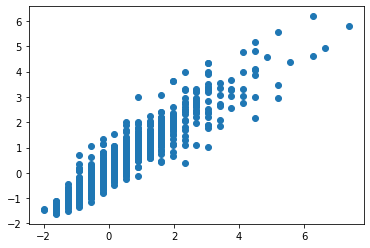

In [504]:
plt.scatter(evals_CO_2[0], evals_CO_2[1])

In [505]:
import pickle

pickle.dump(scalerX_train, open('x_train_scaler.pkl','wb'))
pickle.dump(scalerX_test, open('x_test_scaler.pkl','wb'))
pickle.dump(scalerY_train, open('y_train_scaler.pkl','wb'))
pickle.dump(scalerY_test, open('y_test_scaler.pkl','wb'))
#sc = pickle.load(open('file/path/scaler.pkl','rb'))

In [571]:
#Predicting CO from APPA2

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa2_weather.iloc[:, 1:27], appa2_weather.iloc[:, 28] , test_size=0.2, random_state=42)

import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(26, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX_train = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX_train.transform(X_train)
scalerX_test = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX_test.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    lr = 0.001
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum = 0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}, learning rate {lr/(1+(epoch/10))}")
        optimizer = torch.optim.SGD(net.parameters(), lr=lr/(1+(epoch/10)), momentum = 0.3)

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_CO_2 = evaluate_model(test_dl, bm)

print(f"{appa2_weather.columns[28]}:")
print(f"Range of CO: {appa2_weather.CO.max()-appa2_weather.CO.min()}")
print(f"Mean of CO: {appa2_weather.CO.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_train.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_train.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_train.inverse_transform(evals_CO_2[1]),  scalerY_train.inverse_transform(evals_CO_2[0]))}")

epoch 0 done, loss 0.07216788828372955, learning rate 0.001
epoch 1 done, loss 0.2692101001739502, learning rate 0.0009090909090909091
epoch 2 done, loss 0.05387271195650101, learning rate 0.0008333333333333334
epoch 3 done, loss 0.06952694058418274, learning rate 0.0007692307692307692
epoch 4 done, loss 0.21661114692687988, learning rate 0.0007142857142857144
epoch 5 done, loss 0.0005814482574351132, learning rate 0.0006666666666666666
epoch 6 done, loss 0.002172197448089719, learning rate 0.000625
epoch 7 done, loss 0.025957554578781128, learning rate 0.0005882352941176471
epoch 8 done, loss 0.025076739490032196, learning rate 0.0005555555555555556
epoch 9 done, loss 0.0004063068190589547, learning rate 0.0005263157894736842
epoch 10 done, loss 0.14338472485542297, learning rate 0.0005
epoch 11 done, loss 8.245601202361286e-05, learning rate 0.0004761904761904762
epoch 12 done, loss 0.06135185435414314, learning rate 0.00045454545454545455
epoch 13 done, loss 0.04098763316869736, lea

In [673]:
appa1_normalized = pd.read_csv("exports/normalized_schaira_appa1_2.csv")

In [674]:
appa1_normalized = appa1_normalized.drop(columns=["Unnamed: 0"], axis=1)
appa1_normalized = appa1_normalized.rename(columns={"ts":"Time"})
appa1_normalized.Time = pd.to_datetime(appa1_normalized.Time)

In [678]:
appa1_normalized.head()
appa1_norm = pd.read_csv("exports/appa1_hr.csv")
weather = pd.read_csv("exports/weather_data.csv")
weather = weather.rename(columns={"date":"Time"})
weather.Time = pd.to_datetime(weather.Time)
appa1_norm.Time = pd.to_datetime(appa1_norm.Time)
appa1_normalized.Time = pd.to_datetime(appa1_normalized.Time)
appa1_norm.Time = appa1_norm.Time.dt.tz_localize(None)
#appa1_norm = appa1_norm.merge(weather, how='left', on="Time")
appa1_norm = appa1_norm.merge(appa1_normalized, how='left', on="Time")
appa1_norm = appa1_norm.drop(columns="Unnamed: 0")
appa1_norm = appa1_norm.dropna()

In [679]:
appa1_norm.head()

,Time,Rs1,Rs2,Rs3,Rs4,Rs5,Rs6,Rs7,Rs8,Rh1,...,Temperature,Relative_Humidity,Pressure,VOC,time,Biossido di Azoto,PM10,Ozono,Biossido Zolfo,PM2.5
0,2019-08-26 18:00:00,8.442924e+06,8.519749e+07,3.660411e+08,3.550200e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,76.730000,...,27.643333,54.935000,988.243333,378.862667,2019-08-26 18:00:00+00:00,0.040746,0.050112,0.034491,0.034296,0.057669
1,2019-08-27 16:00:00,3.688220e+07,1.310720e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,4.990000e+08,73.050000,...,28.375000,53.660000,992.775000,502.152167,2019-08-27 16:00:00+00:00,0.022019,0.032481,0.082238,0.033811,0.049758
2,2019-08-27 17:00:00,1.543209e+07,3.426140e+07,1.266045e+08,1.270713e+08,4.582075e+08,4.566434e+08,2.093848e+08,1.768738e+08,108.778333,...,34.188333,41.591667,992.486667,482.208167,2019-08-27 17:00:00+00:00,0.036698,0.052469,0.087117,0.033811,0.072723
3,2019-08-27 18:00:00,2.104751e+06,3.888875e+06,4.551243e+06,4.694948e+06,4.990000e+08,4.770748e+08,1.220728e+08,7.505715e+07,121.210000,...,37.861667,33.023333,992.485000,488.320333,2019-08-27 18:00:00+00:00,0.042203,0.064961,0.079451,0.033811,0.072723
4,2019-08-27 19:00:00,1.932827e+06,3.206606e+06,5.333100e+06,5.011784e+06,4.339941e+08,3.442738e+08,1.231950e+08,7.588989e+07,121.126667,...,37.811667,33.371667,992.901667,500.728000,2019-08-27 19:00:00+00:00,0.055048,0.082451,0.061330,0.033811,0.091861


In [697]:
!pip3 install plotly

     |████████████████████████████████| 15.2 MB 8.4 MB/s eta 0:00:01


In [708]:
!sudo apt-get install python-sklearn  

Password:
sudo: a password is required


In [709]:
import math
import locale
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
#import plotly.express as px
from tqdm import tqdm
from joblib import dump, load
import pickle

pollu = ["Biossido di Azoto", "Ossido di Carbonio", "PM10", "Ozono", "PM2.5", "Biossido Zolfo"]
POLLUTANT = "O3"
pollu_dict = {
    "AO2": "Biossido di Azoto",
    "CO2": "Ossido di Carbonio",
    "PM10": "PM10",
    "O3": "Ozono",
    "PM2.5": "PM2.5",
    "SO2": "Biossido Zolfo"
}
MODEL_FILE = f"models/{pollu_dict[POLLUTANT]}.joblib"
FILE = "data/test_day_data.csv"
try:
    model = load(MODEL_FILE)
    print("opened .joblib")
except:
    model = pickle.load(open(MODEL_FILE.split('.')[0]+'.sav', 'rb'))
    print("opened .sav")
day_data = pd.read_csv(FILE)
day_data.Data = pd.to_datetime(day_data.Data, format = "%Y-%m-%d %H:%M:%S")
day_data["real_ppm"]= day_data.Valore * model.predict(day_data.Data.dt.day_of_year[:,np.newaxis])

ImportError: cannot import name '_check_feature_names_in' from 'sklearn.utils.validation' (/Users/nikhilpesaladinne/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py)

In [695]:
#Predicting NO2 Normalized
scores_mean = []
scores_median = []
y_test_date = pd.DataFrame()
y_pred_date = pd.DataFrame()
for i in tqdm(range(5),total = 5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_norm.iloc[:, 0:29], appa1_norm.iloc[:, 31] , test_size=0.2, random_state=i)
    y_test_date["Date"] = X_test.Time
    y_pred_date["Date"] = X_test.Time
    X_train = X_train.drop(columns=["Time"])
    X_test = X_test.drop(columns=["Time"])
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    y_test_date["Value"] = y_test
    y_pred_date["Value"] = y_test_pred
    y_test = y_test_date.Value * model.predict(y_test_date.Date.dt.day_of_year[:,np.newaxis])
    y_test_pred = y_pred_date.Value * model.predict(y_pred_date.Date.dt.day_of_year[:,np.newaxis])
    print(mean_absolute_error(y_test_pred, y_test))
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Normalized Predicting NO2")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")

  0%|          | 0/5 [01:12<?, ?it/s]


NameError: name 'model' is not defined

In [691]:
#Predicting O3 Normalized
scores_mean = []
scores_median = []
for i in range(5):
    X_train, X_test, y_train, y_test = train_test_split(appa1_weather.iloc[:, 1:29], appa1_weather.iloc[:, 33] , test_size=0.2, random_state=i)
    reg = GradientBoostingRegressor(random_state=i, n_estimators=800).fit(X_train, y_train)
    y_test_pred = reg.predict(X_test)
    scores_mean.append(mean_absolute_error(y_test_pred, y_test))
    scores_median.append(median_absolute_error(y_test_pred, y_test))
print("Gradient Boosted Weather Predicting O3")
print(f"{sum(scores_mean)/len(scores_mean)} mean absolute error with a standard deviation of {statistics.stdev(scores_mean)}")
print(f"{sum(scores_median)/len(scores_median)} median absolute error with a standard deviation of {statistics.stdev(scores_median)}")


KeyboardInterrupt: 

In [553]:
appa1_norm = appa1_norm.dropna()

In [565]:
#Predicting Ozone from APPA1_normalized

#appa1_outlier = pd.read_csv("exports/appa1_hr_cropped.csv")
#appa1_hr_cropped = appa1_hr_cropped.drop("Unnamed: 0", axis=1)
X_train, X_test, y_train, y_test = train_test_split(appa1_norm.iloc[:, 1:29], appa1_norm.iloc[:, 31] , test_size=0.2, random_state=42)
import torch as T
from torch import nn, optim, as_tensor
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.init import *
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import copy
import random
from sklearn import preprocessing

device = T.device("cpu")
  
class Net(T.nn.Module):
    def __init__(self):
      super(Net, self).__init__()

      self.fc1 = nn.Linear(28, 600)
      self.fc2 = nn.Linear(600,300)
      self.fc3 = nn.Linear(300,10)
      self.oupt = nn.Linear(10, 1)

      #T.nn.init.xavier_uniform_(self.hid1.weight)
      #T.nn.init.zeros_(self.hid1.bias)
      #T.nn.init.xavier_uniform_(self.hid2.weight)
      #T.nn.init.zeros_(self.hid2.bias)
      #T.nn.init.xavier_uniform_(self.oupt.weight)
      #T.nn.init.zeros_(self.oupt.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.oupt(x)  # no activation
        return x

net = Net()
y_train = np.array([[i] for i in list(y_train)])
y_test = np.array([[i] for i in list(y_test)])

loss_fn = T.nn.CrossEntropyLoss()
#optimizer = T.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scalerX_train = preprocessing.StandardScaler().fit(X_train)
X_train = scalerX_train.transform(X_train)
scalerX_test = preprocessing.StandardScaler().fit(X_test)
X_test = scalerX_test.transform(X_test)
scalerY_train = preprocessing.StandardScaler().fit(y_train)
y_train = scalerY_train.transform(y_train)
scalerY_test = preprocessing.StandardScaler().fit(y_test)
y_test = scalerY_train.transform(y_test)
data_train = []
data_test = []
i = 0
for row in X_train:
    data_train.append((row, y_train[i]))
    i = i+1
i = 0
for row in X_test:
    data_test.append((row, y_test[i]))
    i = i+1

train_dl = DataLoader(data_train, batch_size=150, shuffle=True)
test_dl = DataLoader(data_test, batch_size=150, shuffle=True)

def train_model(train_dl, model):
    global bm
    best_loss = float("inf")
    # define the optimization
    criterion = nn.MSELoss()
    lr = 0.001
    loss_0 = 1.0
    loss = 1.0
    optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum = 0.3)
    # enumerate epochs
    for epoch in range(50):
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            for i, inp in enumerate(inputs):
                #print(inp)
                yhat = model(inp.float())
                # calculate loss
                loss = criterion(yhat, targets[i].float())
                # credit assignment
                loss.backward()
            # update model weights
            optimizer.step()
        if best_loss > loss:
            bm = copy.deepcopy(model)
            best_loss = loss
        print(f"epoch {epoch} done, loss {loss}, learning rate {lr/(1+(epoch/10))}")
        optimizer = torch.optim.SGD(net.parameters(), lr=lr/(1+(epoch/10)), momentum = 0.3)

def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        for i, inp in enumerate(inputs):
            yhat = model(inp.float())
            # retrieve numpy array
            yhat = yhat.detach().numpy()
            actual = targets[i].numpy()
            # store
            predictions.append(yhat)
            actuals.append(actual)
    predictions, actuals = np.vstack(predictions), np.vstack(actuals)
    # calculate accuracy
    acc = (actuals, predictions)
    return acc

train_model(train_dl, net)
from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
evals_Ozone_1 = evaluate_model(test_dl, net)

epoch 0 done, loss 0.045159660279750824, learning rate 0.001
epoch 1 done, loss 0.05162212997674942, learning rate 0.0009090909090909091
epoch 2 done, loss 0.4694896936416626, learning rate 0.0008333333333333334
epoch 3 done, loss 0.003087543649598956, learning rate 0.0007692307692307692
epoch 4 done, loss 0.0307316891849041, learning rate 0.0007142857142857144
epoch 5 done, loss 0.26552122831344604, learning rate 0.0006666666666666666
epoch 6 done, loss 0.5283229947090149, learning rate 0.000625
epoch 7 done, loss 0.5866996049880981, learning rate 0.0005882352941176471
epoch 8 done, loss 0.05220361799001694, learning rate 0.0005555555555555556
epoch 9 done, loss 0.0749320536851883, learning rate 0.0005263157894736842
epoch 10 done, loss 0.019448667764663696, learning rate 0.0005
epoch 11 done, loss 1.857018232345581, learning rate 0.0004761904761904762
epoch 12 done, loss 3.4049361374854925e-07, learning rate 0.00045454545454545455
epoch 13 done, loss 0.0024349468294531107, learning r

In [566]:
evals_Ozone_1 = evaluate_model(test_dl, bm)

In [567]:
print(f"{appa1_norm.columns[31]}:")
print(f"Range of Ozone: {appa1_norm.Ozono.max()-appa1_norm.Ozono.min()}")
print(f"Mean of Ozone: {appa1_norm.Ozono.mean()}")
print(f"Mean Squared Error: {mean_squared_error(evals_Ozone_1[1], evals_Ozone_1[0], squared=False)}")
print(f"Median absolute error: {median_absolute_error(evals_Ozone_1[1], evals_Ozone_1[0])}")
print(f"Mean Absolute Error: {mean_absolute_error(evals_Ozone_1[1], evals_Ozone_1[0])}")

Ozono:
Range of Ozone: 1818.0740989603055
Mean of Ozone: 2.14200337840816
Mean Squared Error: 0.671759666243064
Median absolute error: 0.3290342262952921
Mean Absolute Error: 0.47166652145280413


In [545]:
print(f"{appa1_norm.columns[31]}:")
print(f"Range of Ozone: {appa1_norm.Ozono.max()-appa1_norm.Ozono.min()}")
print(f"Mean of Ozone: {appa1_norm.Ozono.mean()}")
print(f"Mean Squared Error: {mean_squared_error(scalerY_train.inverse_transform(evals_Ozone_1[1]),  scalerY_train.inverse_transform(evals_Ozone_1[0]), squared=False)}")
print(f"Median absolute error: {median_absolute_error(scalerY_train.inverse_transform(evals_Ozone_1[1]),  scalerY_train.inverse_transform(evals_Ozone_1[0]))}")
print(f"Mean Absolute Error: {mean_absolute_error(scalerY_train.inverse_transform(evals_Ozone_1[1]),  scalerY_train.inverse_transform(evals_Ozone_1[0]))}")

Ozono:
Range of CO: 1818.0740989603055
Mean of CO: 2.14200337840816
Mean Squared Error: 15.788241369185112
Median absolute error: 8.014742254395497
Mean Absolute Error: 11.185793517208493
